In [1]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fceu_help import pointer_to_numpy
import scipy
import scipy.misc
import cv2

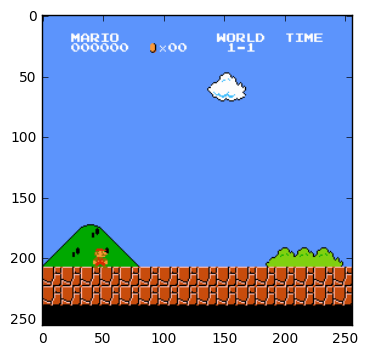

In [2]:
#rom = "mario.nes"

movie = 'adam_test.fm2'

start_t =280
#start_t =195 #happylee4-smb-warpless.fm2'

rom = "mario.nes"
#movie = "Illustrative.fm2"
# rom = "metroid.nes"
#movie = "metroid.fm2"
# start_t = 300
# movie ='lordtom-metroid-100.fm2'
#movie = "metroid-long.fm2"

#rom = 'zelda.nes'
#movie = 'baxter,jprofit22-legendofzelda.fm2'
#movie = 'zelda.fm2'

#rom = 'zelda.nes'
#movie = 'taseditorv1-legendofzelda-allitems.fm2'
#start_t = 900

# rom = "ff.nes"
# movie = 'theaxemanv4-finalfantasy.fm2'
# start_t = 10

#rom = 'dw.nes'
#movie = 'acmlm-dragonwarrior.fm2'
#start_t = 120

#rom = "smb2u.nes"
#movie = "smb2u-2.fm2"
#start_t = 450
emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

for i,i2 in zip(inputs1[:start_t],inputs2[:start_t]):
    emu.stepFull(i, i2)
    
 
def convert_image(img_buffer):
    # TODO: without allocations/reshape?
    screen = pointer_to_numpy(img_buffer)
    return screen.reshape([256, 256, 4]).astype(np.uint8)

img_buffer = fceulib.VectorBytes()
emu.imageInto(img_buffer)
np_image = convert_image(img_buffer)
plt.imshow(np_image)
plt.show()

# img = Image.fromarray(scipy.misc.imresize(np_image,1.0))
# print tesserocr.image_to_text(img) 
    

3306
T: 0


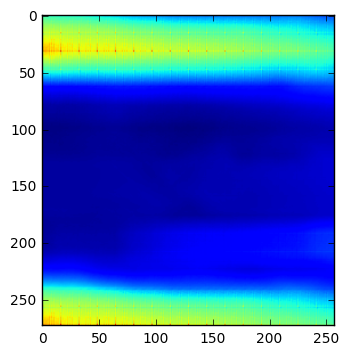

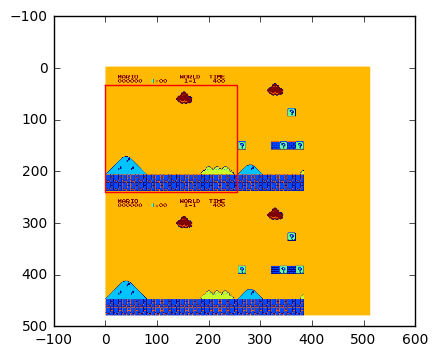

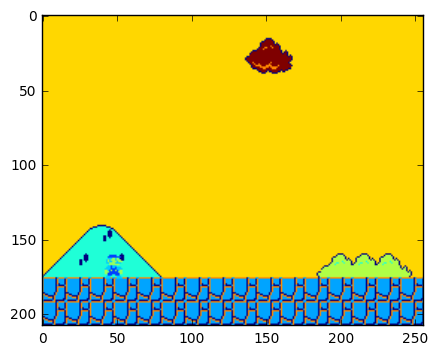

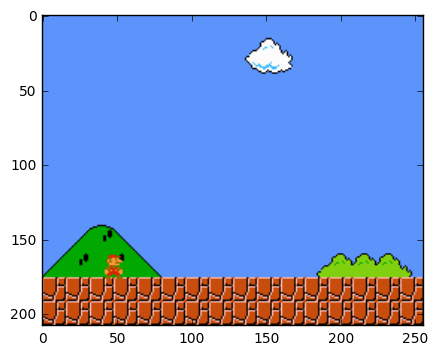

T: 60


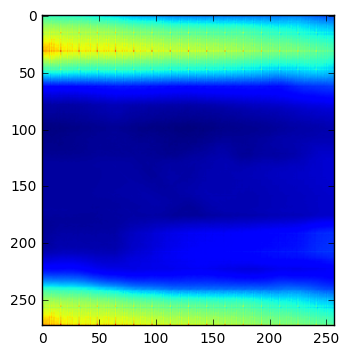

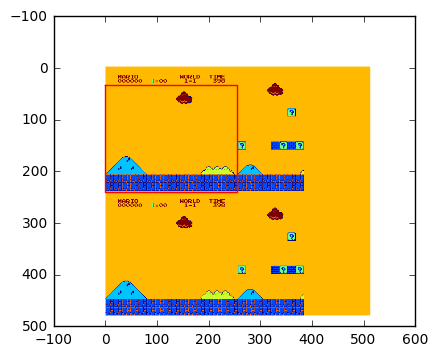

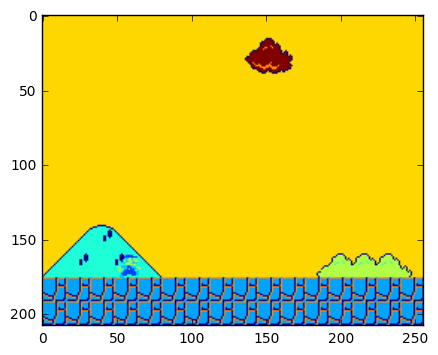

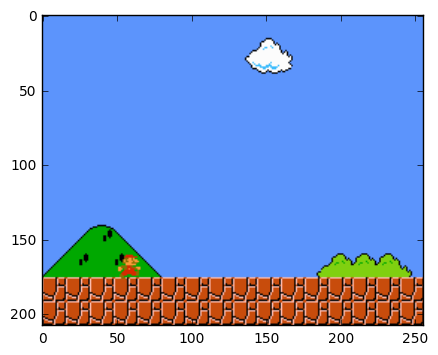

T: 120


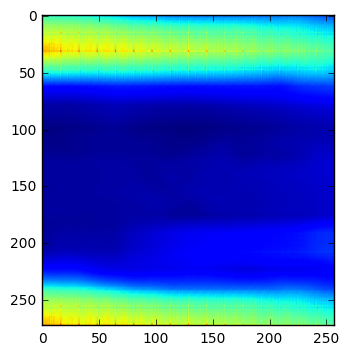

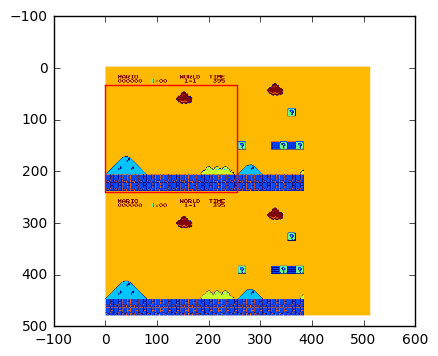

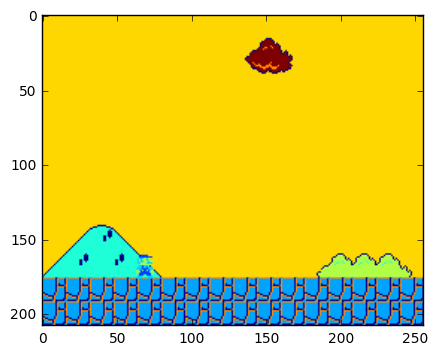

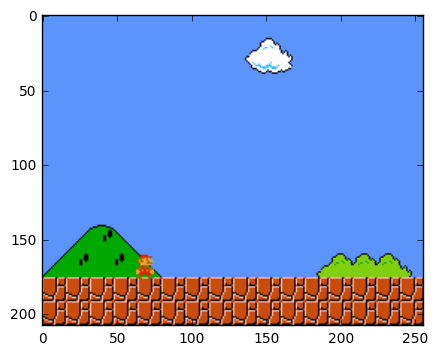

T: 180


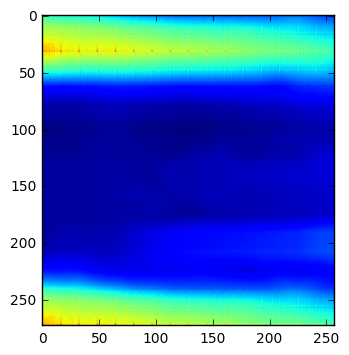

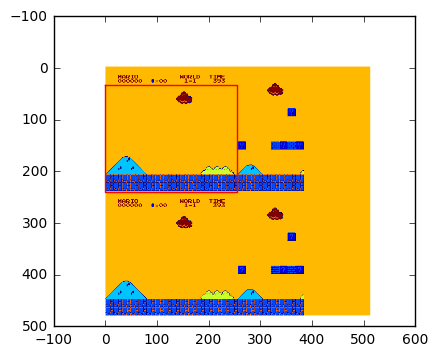

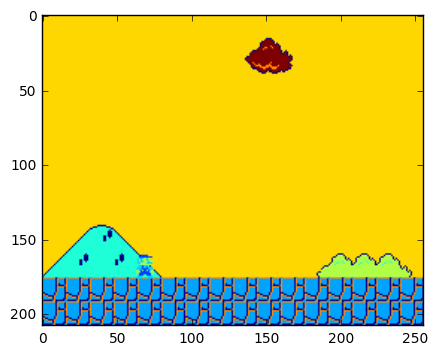

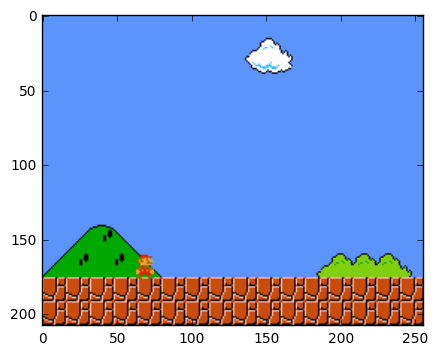

T: 240


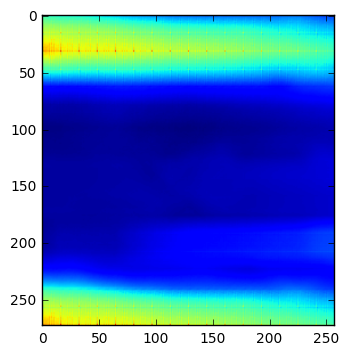

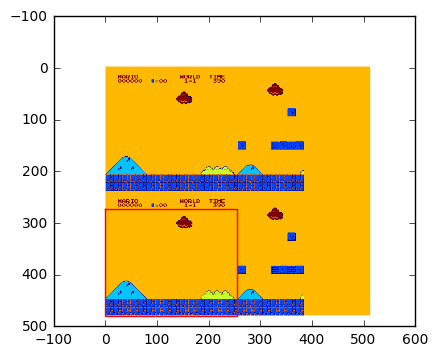

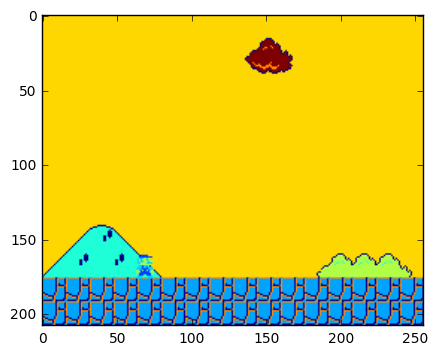

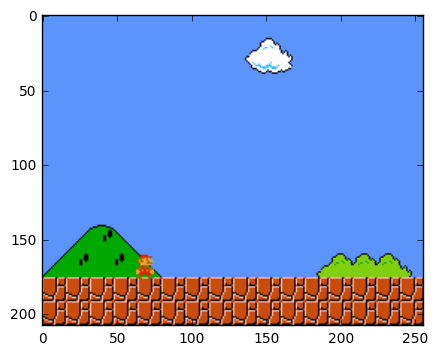

T: 300


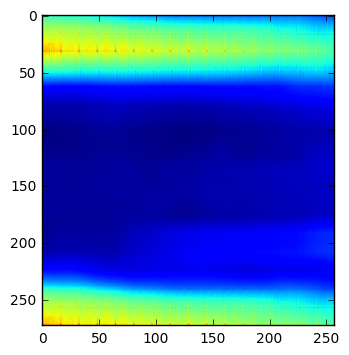

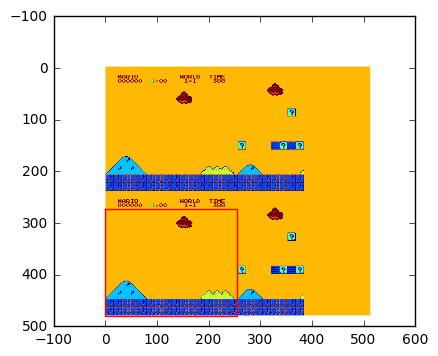

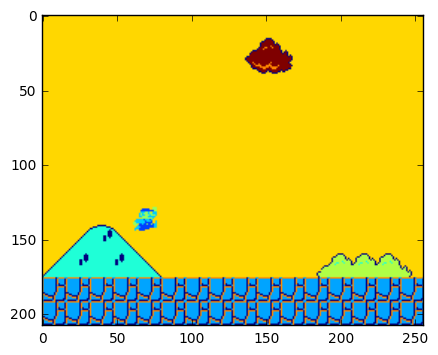

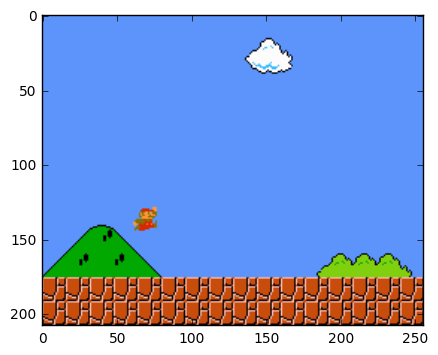

T: 360


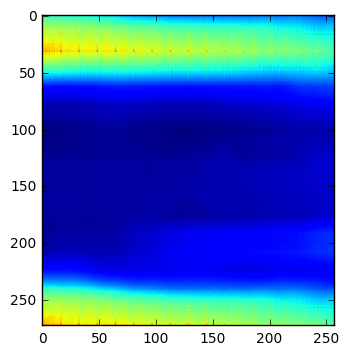

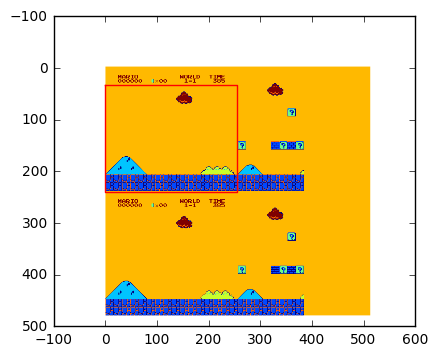

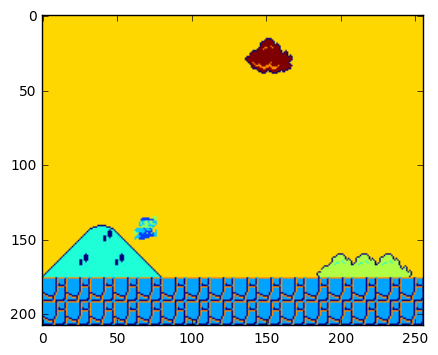

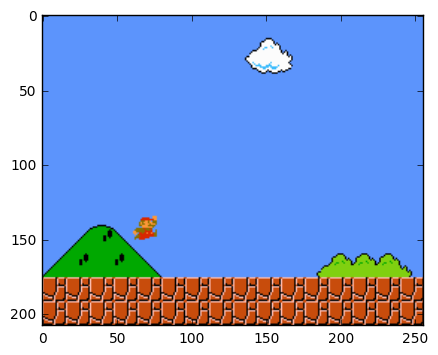

T: 420


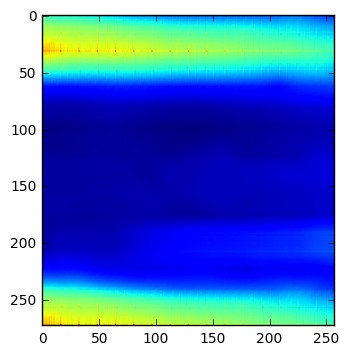

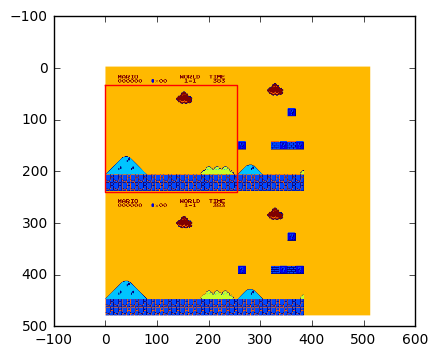

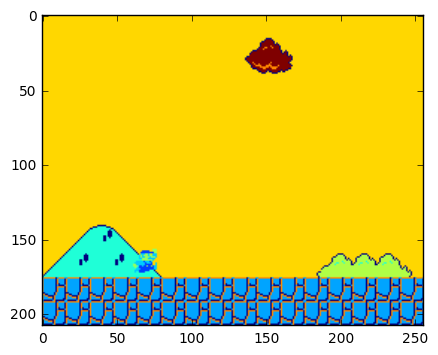

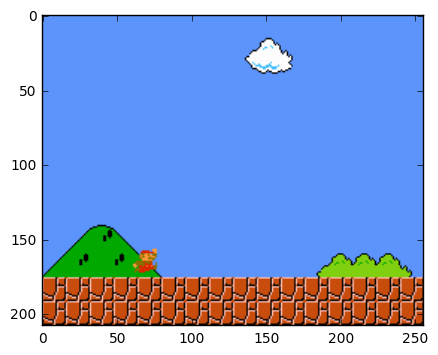

T: 480


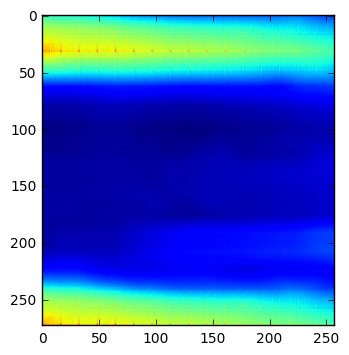

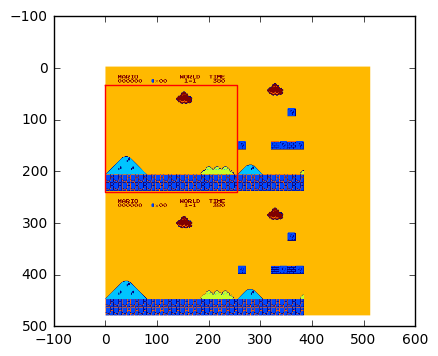

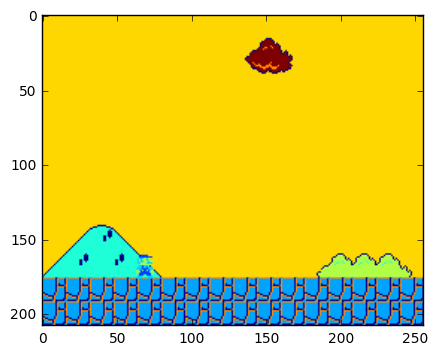

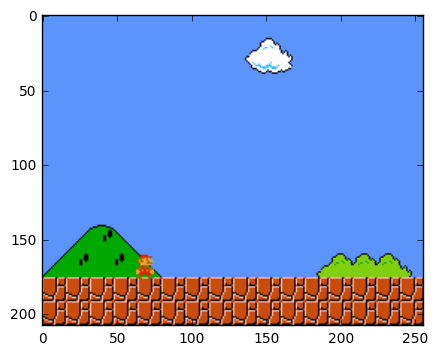

T: 540


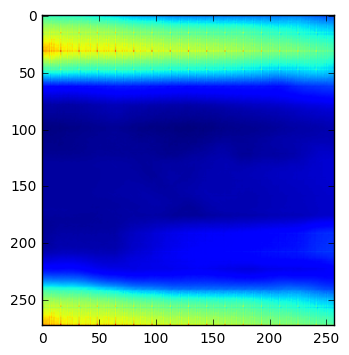

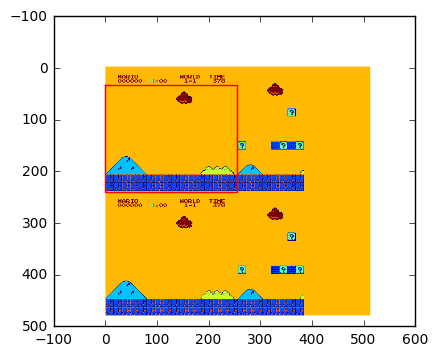

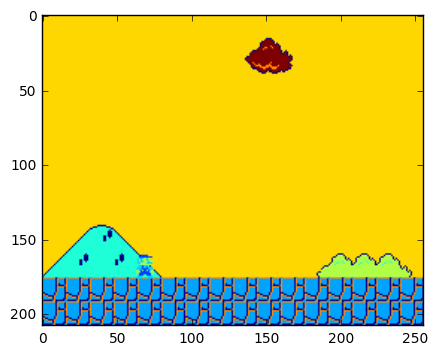

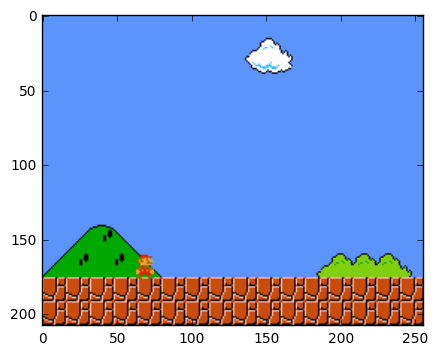

T: 600


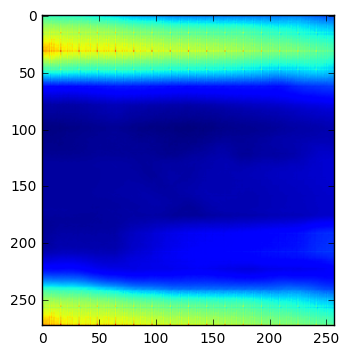

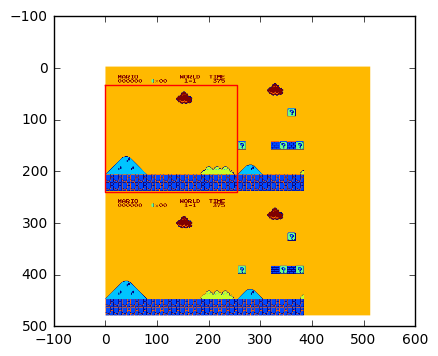

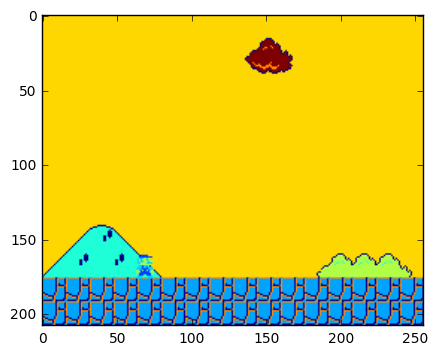

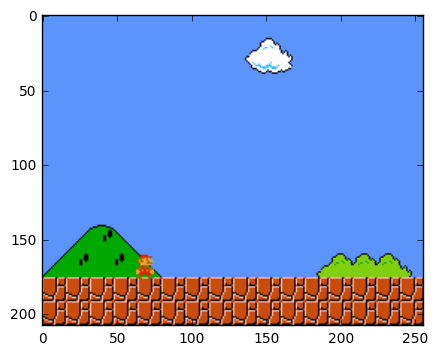

T: 660


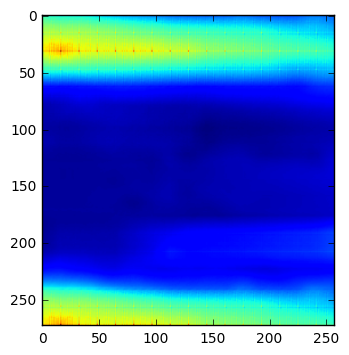

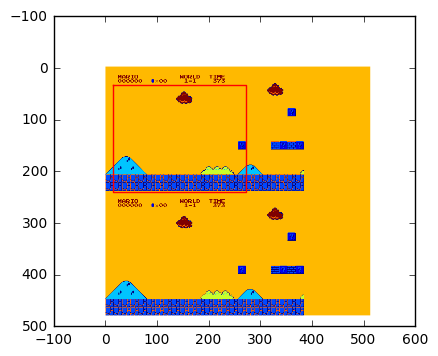

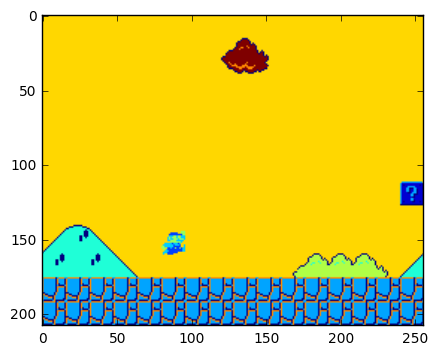

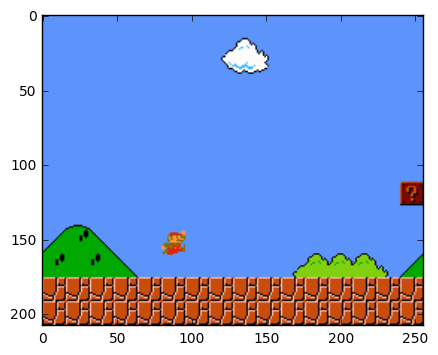

T: 720


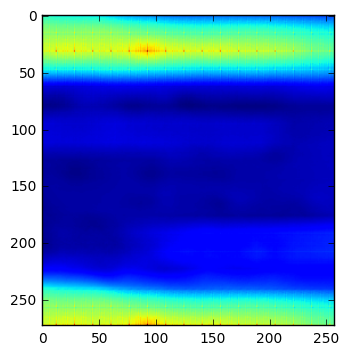

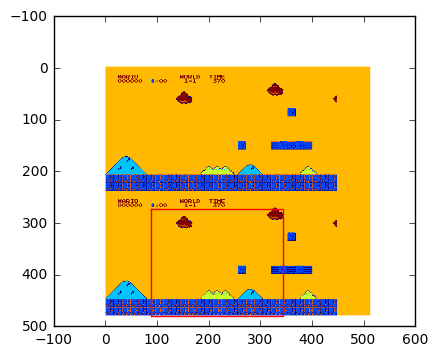

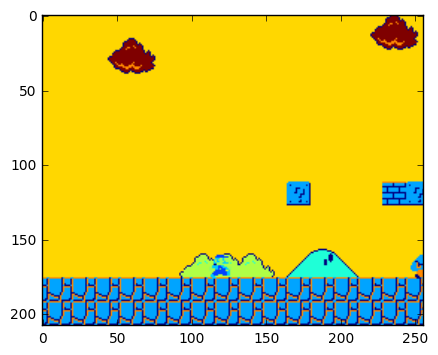

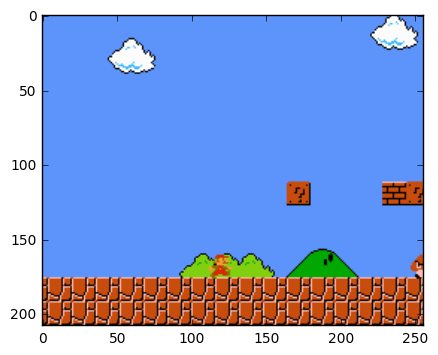

T: 780


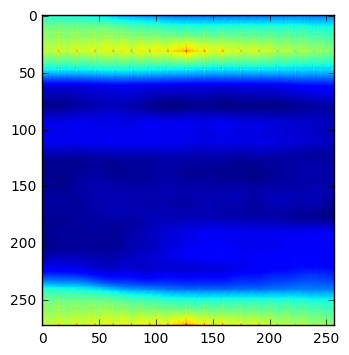

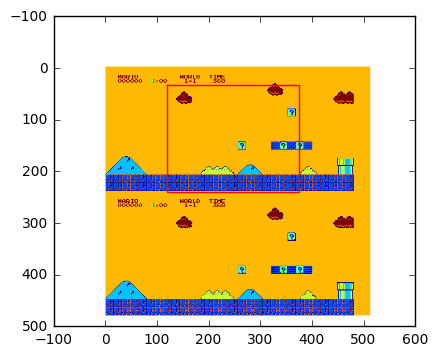

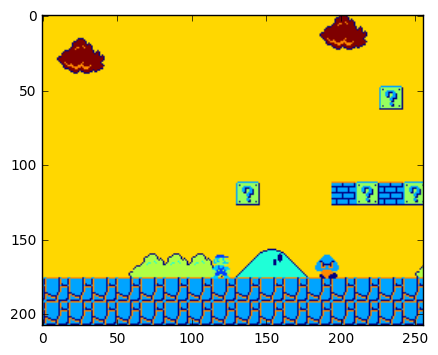

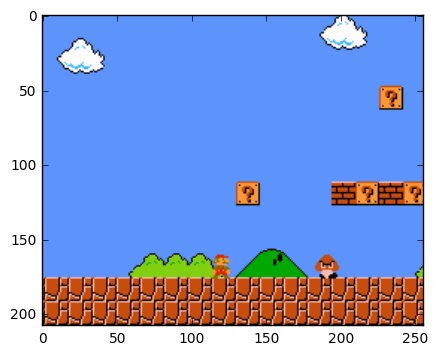

T: 840


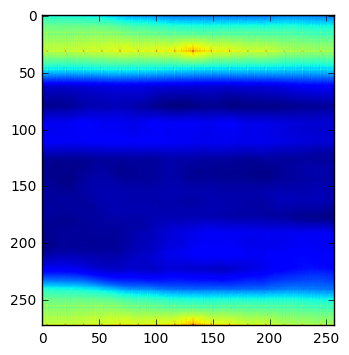

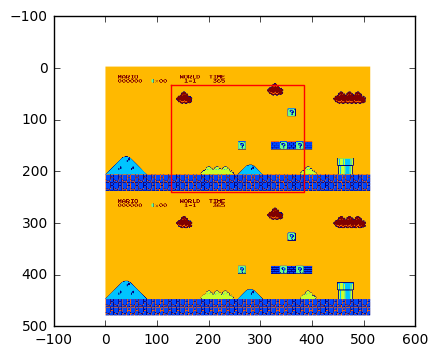

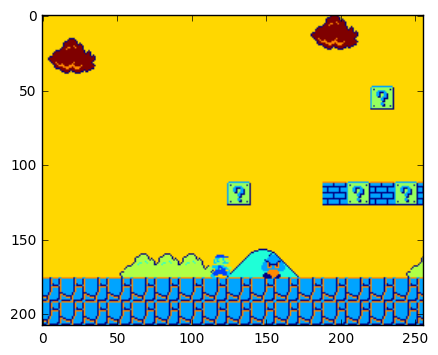

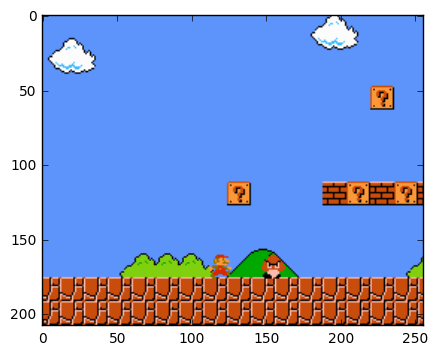

T: 900


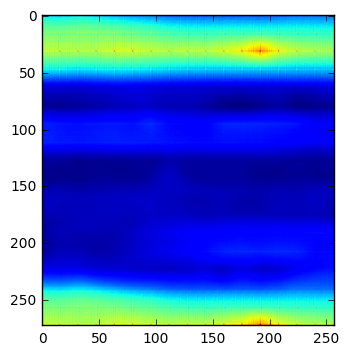

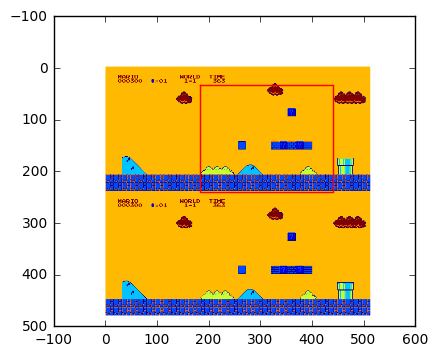

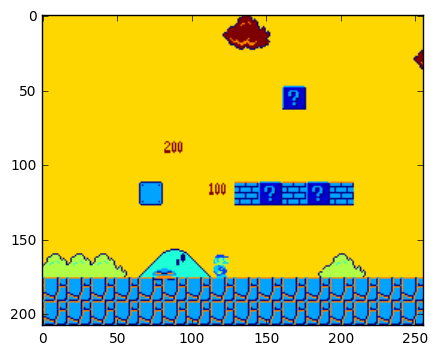

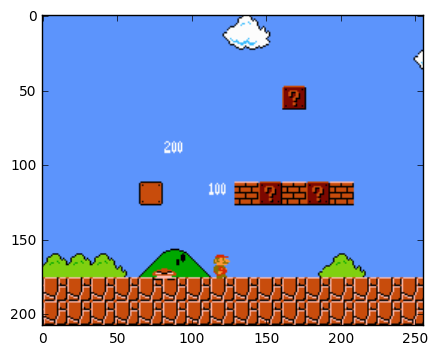

T: 960


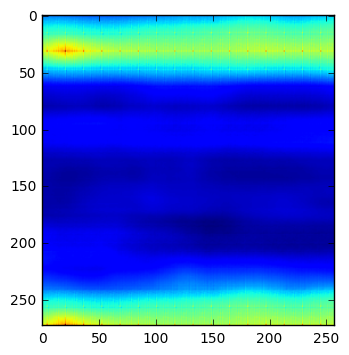

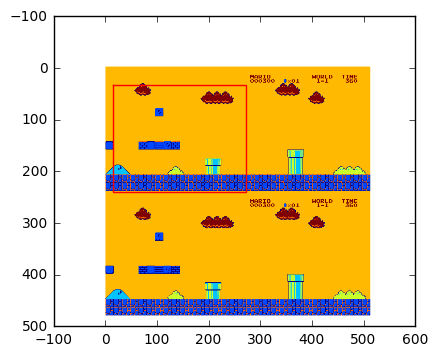

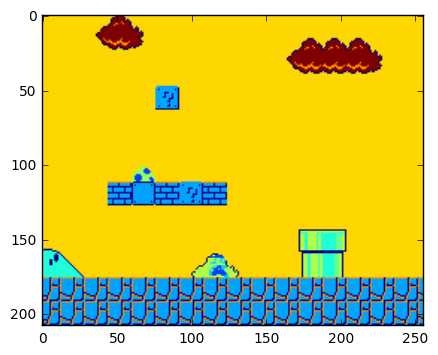

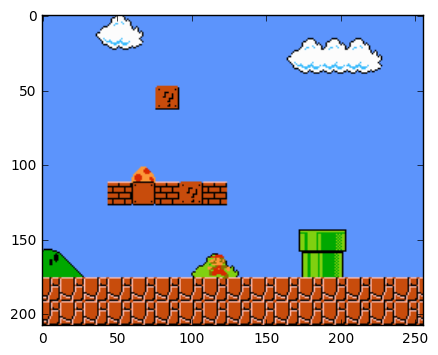

T: 1020


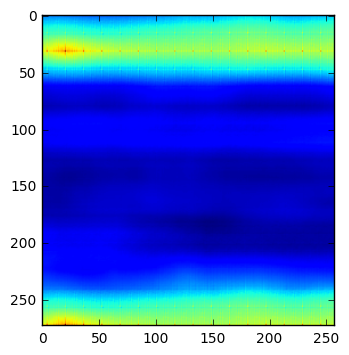

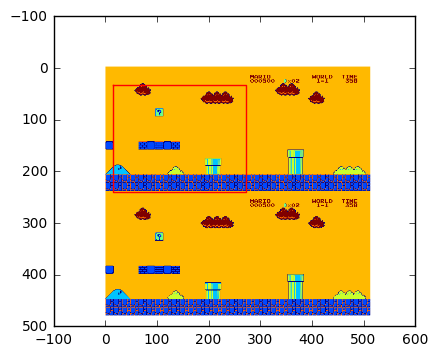

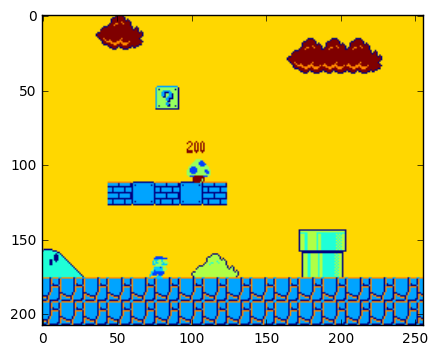

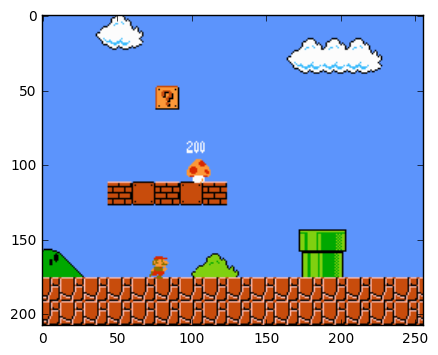

T: 1080


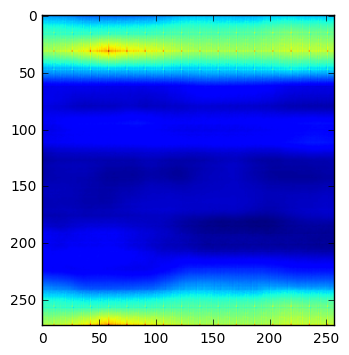

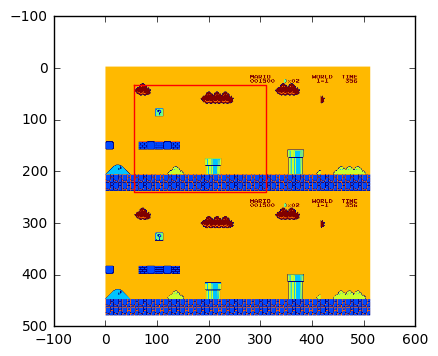

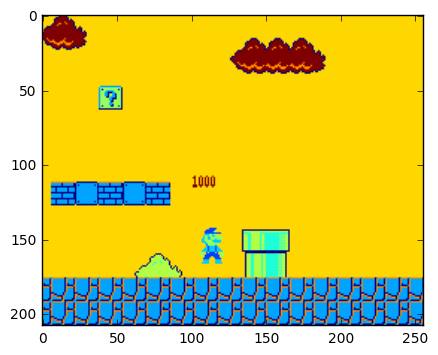

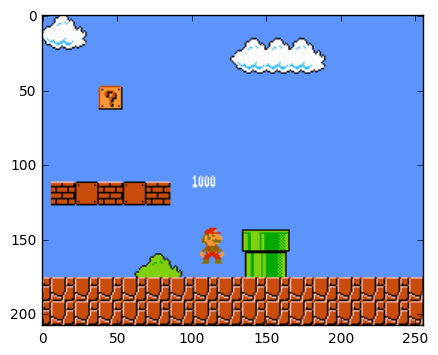

T: 1140


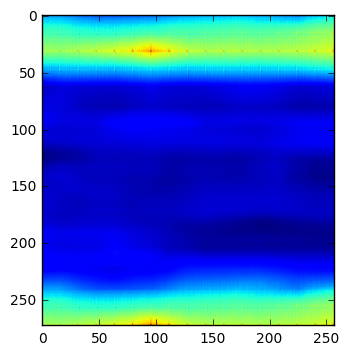

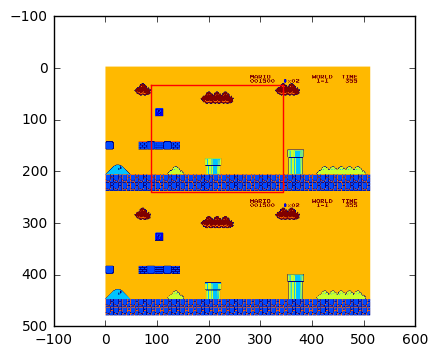

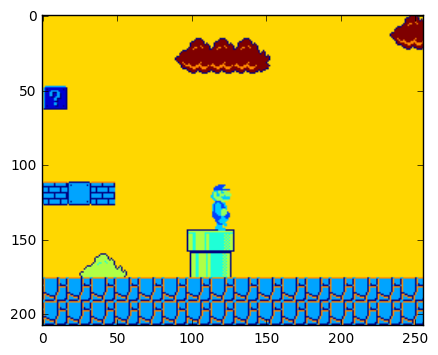

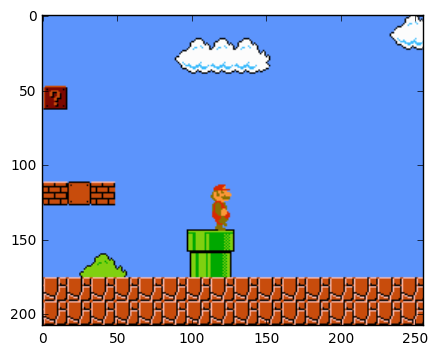

T: 1200


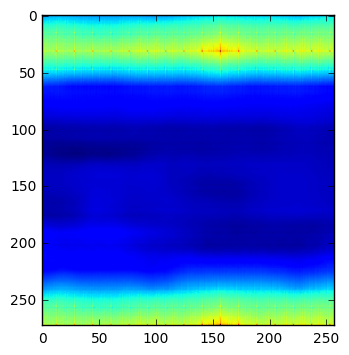

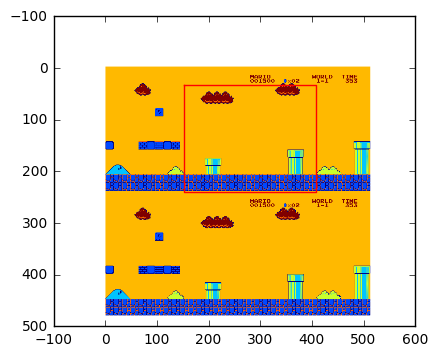

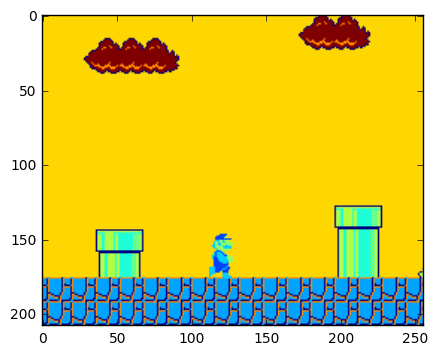

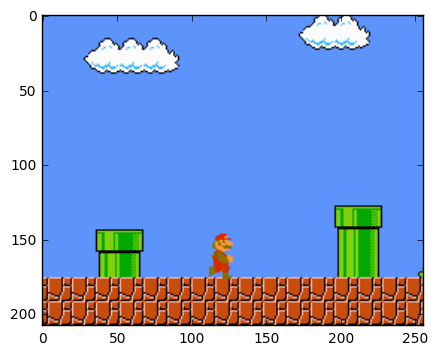

T: 1260


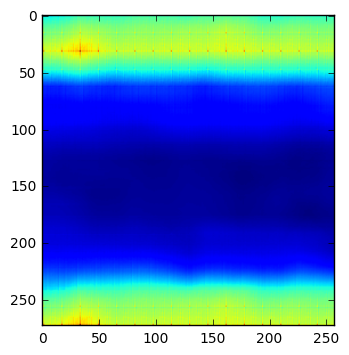

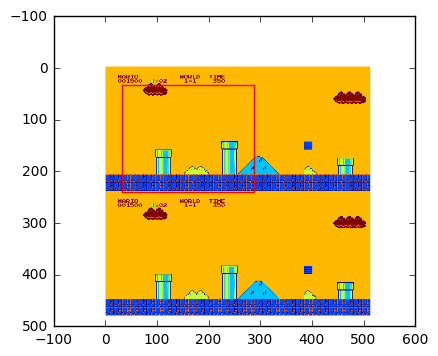

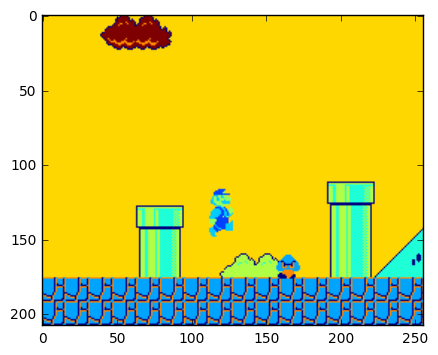

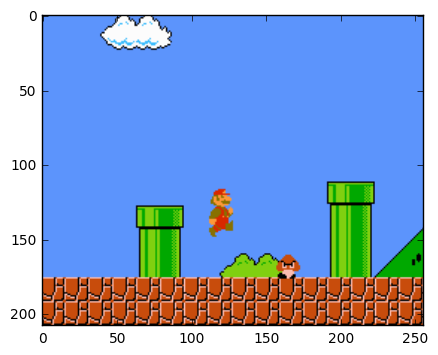

T: 1320


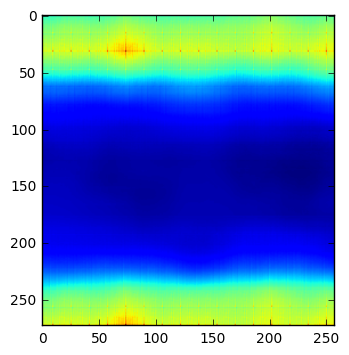

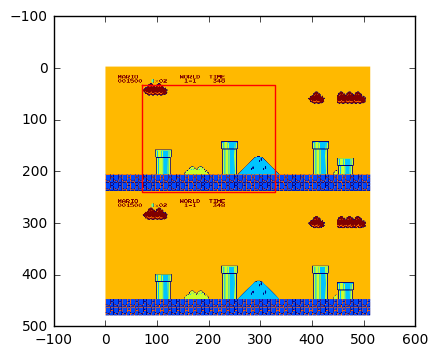

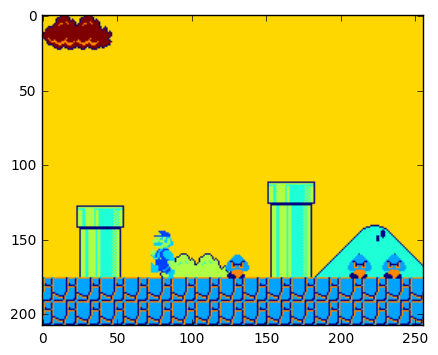

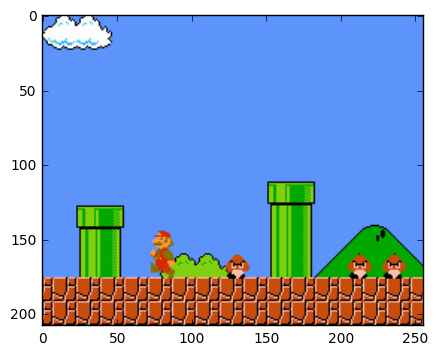

T: 1380


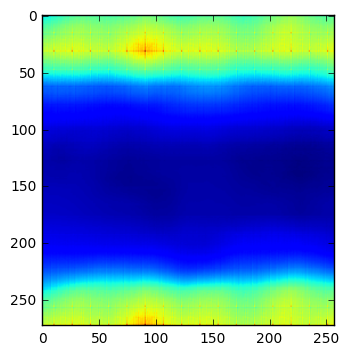

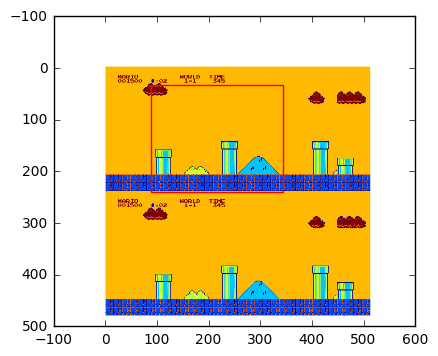

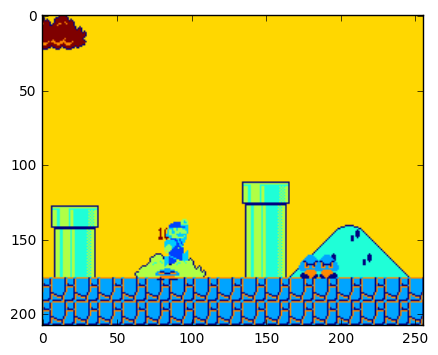

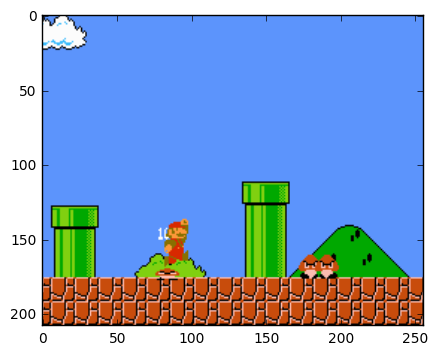

T: 1440


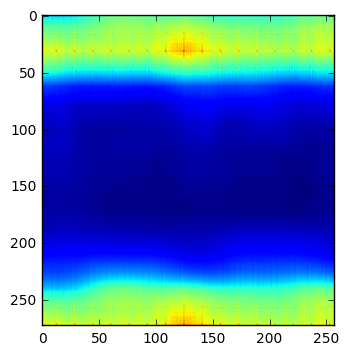

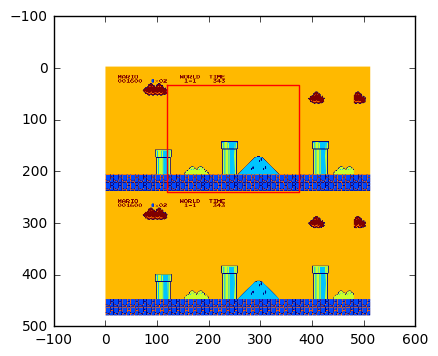

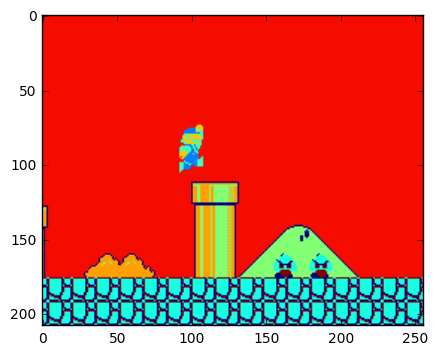

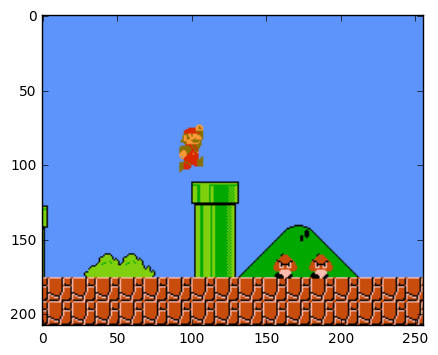

T: 1500


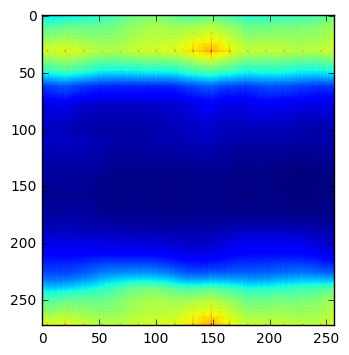

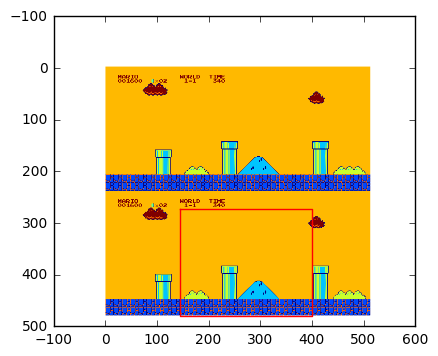

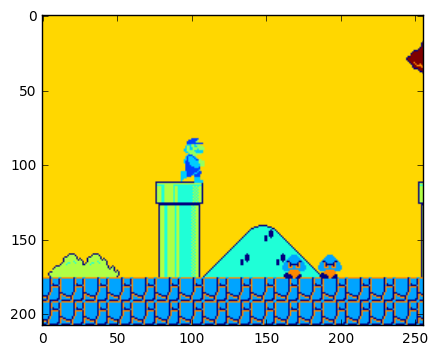

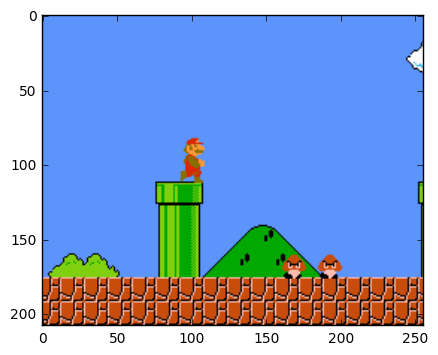

T: 1560


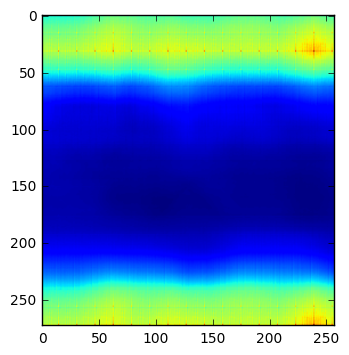

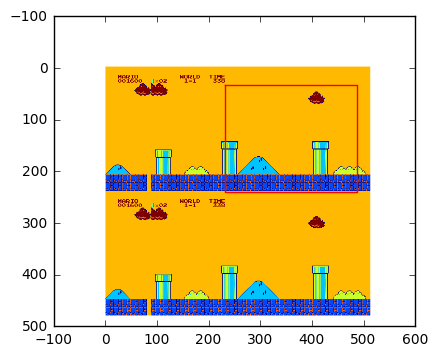

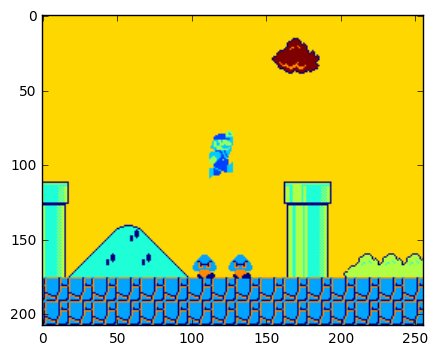

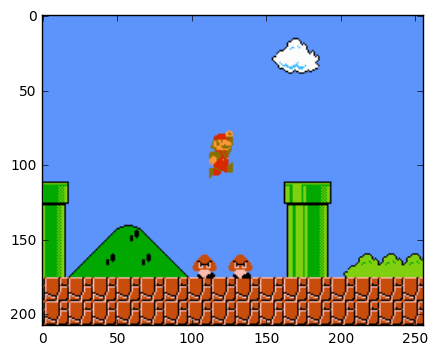

T: 1620


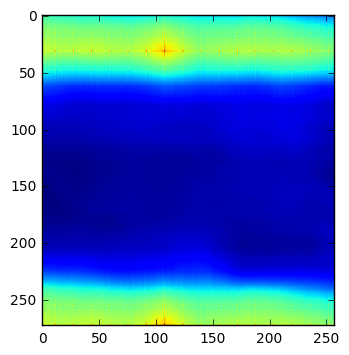

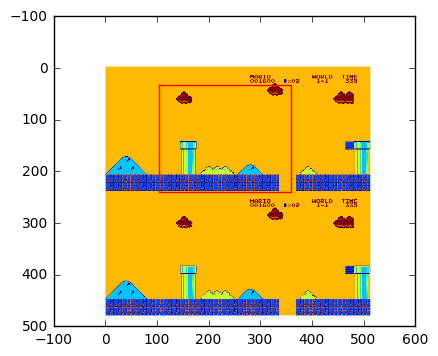

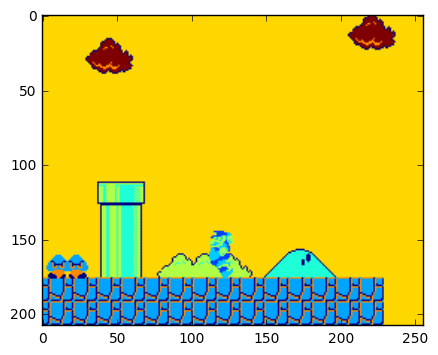

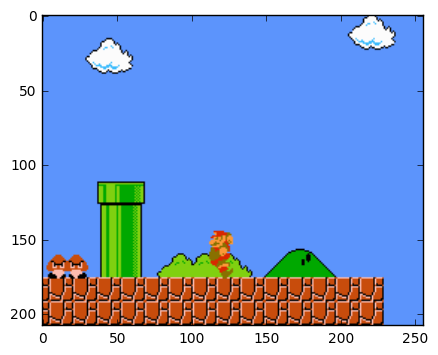

T: 1680


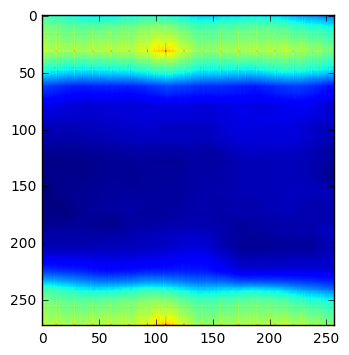

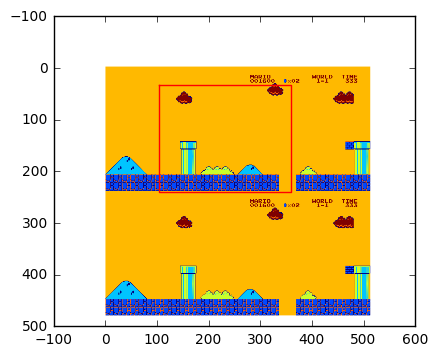

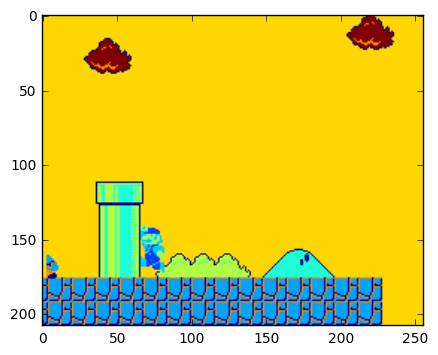

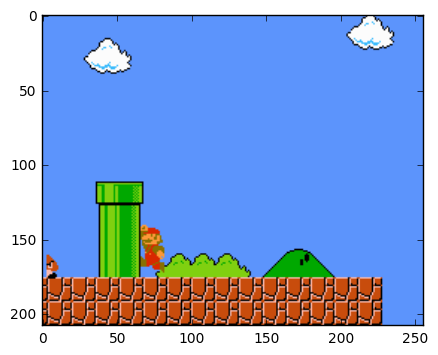

T: 1740


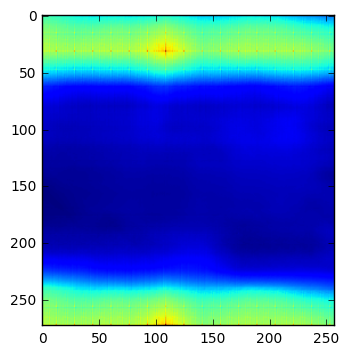

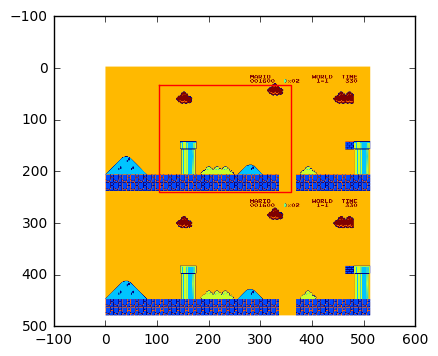

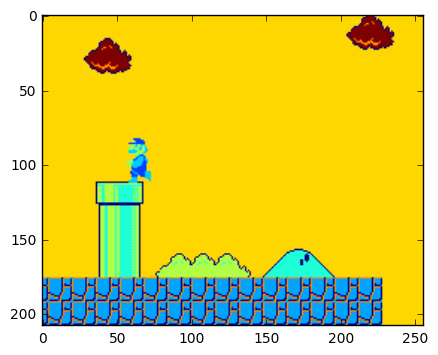

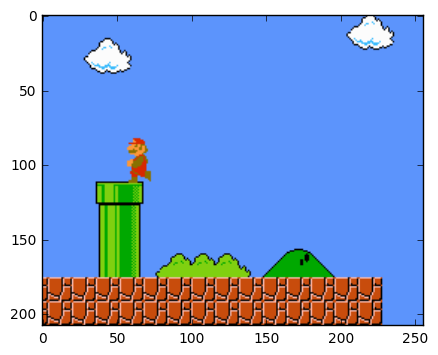

T: 1800


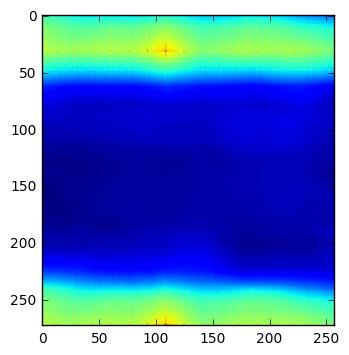

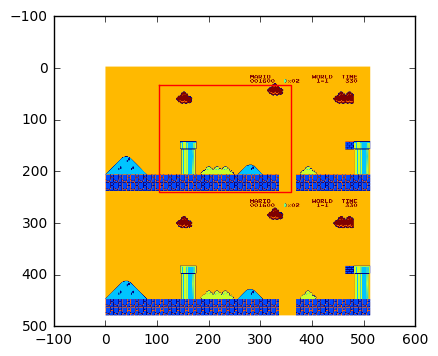

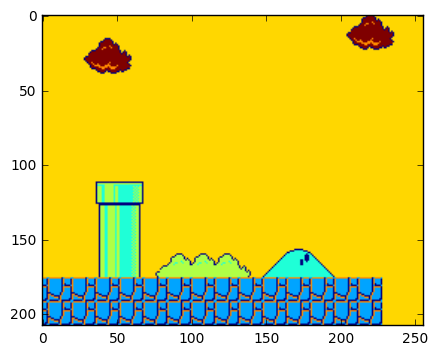

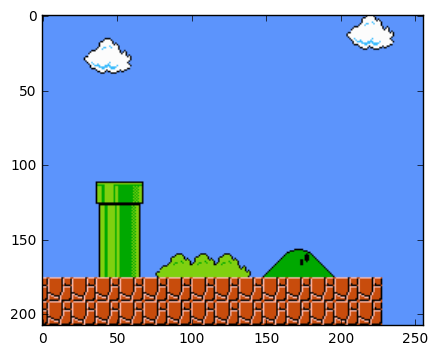

T: 1860


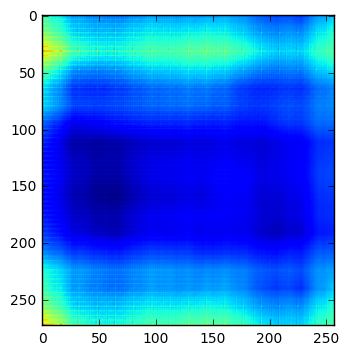

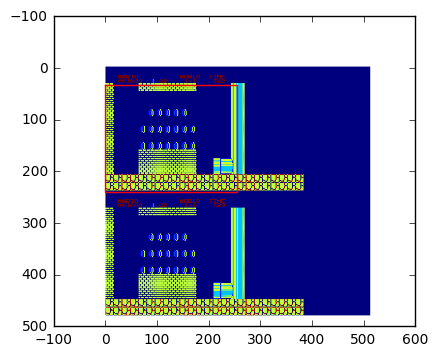

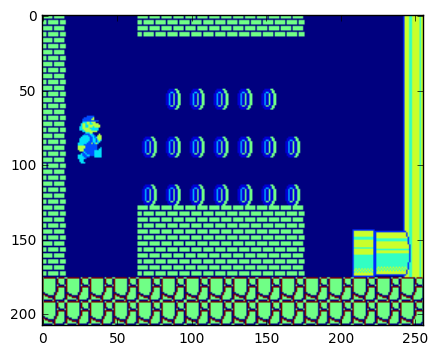

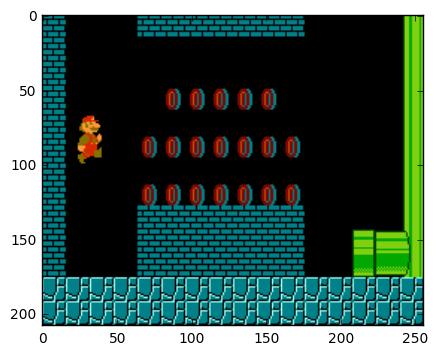

T: 1920


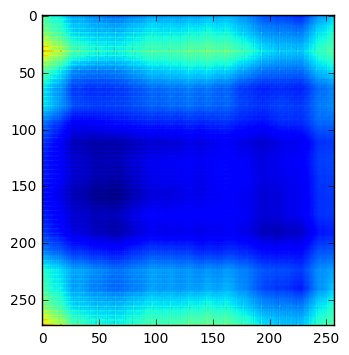

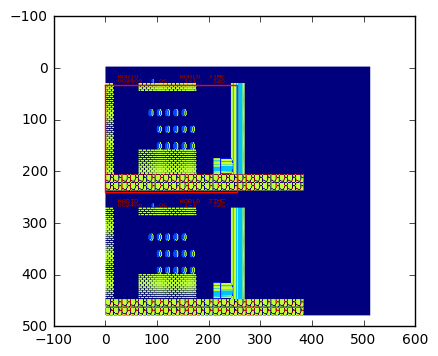

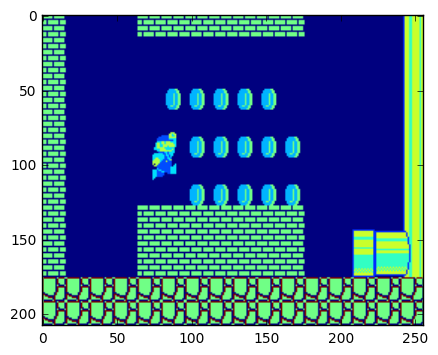

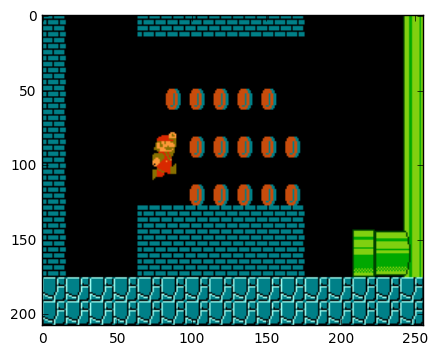

T: 1980


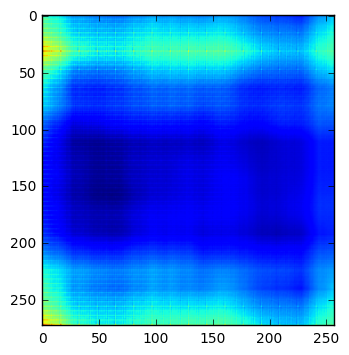

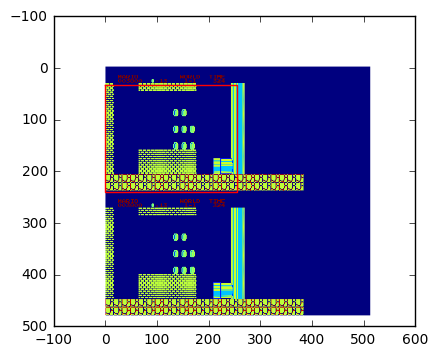

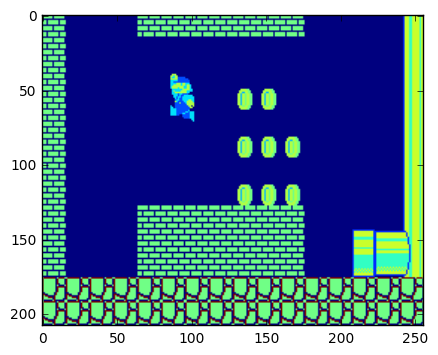

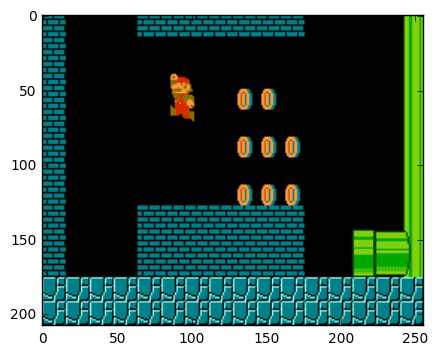

CPU times: user 2min 49s, sys: 29.4 s, total: 3min 18s
Wall time: 2min 36s


In [3]:
%%time

reload(ppu_dump)
end = start_t+2000
print len(inputs1)
#METROID
#scroll_area= (0,0,32,30-0)

#ZELDA
scroll_area= (0,4,32,30-4)

#MARIO, ZELDA2
#scroll_area = (0, 4, 32, 30-4)

ep_data = ppu_dump.ppu_output(emu,
                              inputs1[start_t:end],
                              inputs2=inputs2[start_t:end],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=True,
                              colorized_tiles=False,
                              display=False,
                              test_control=True,
                              peekevery=1,
                            scroll_area= scroll_area )

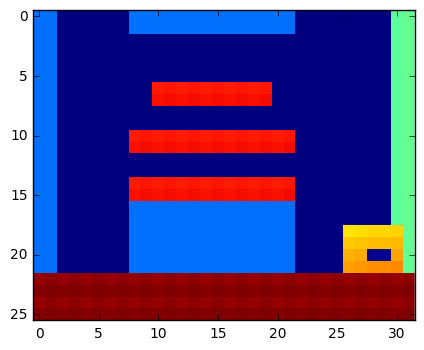

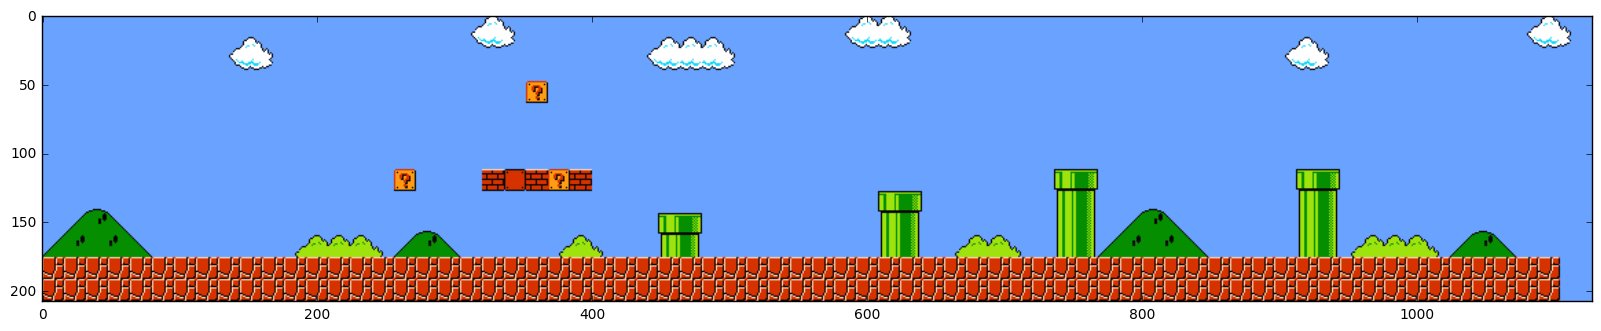

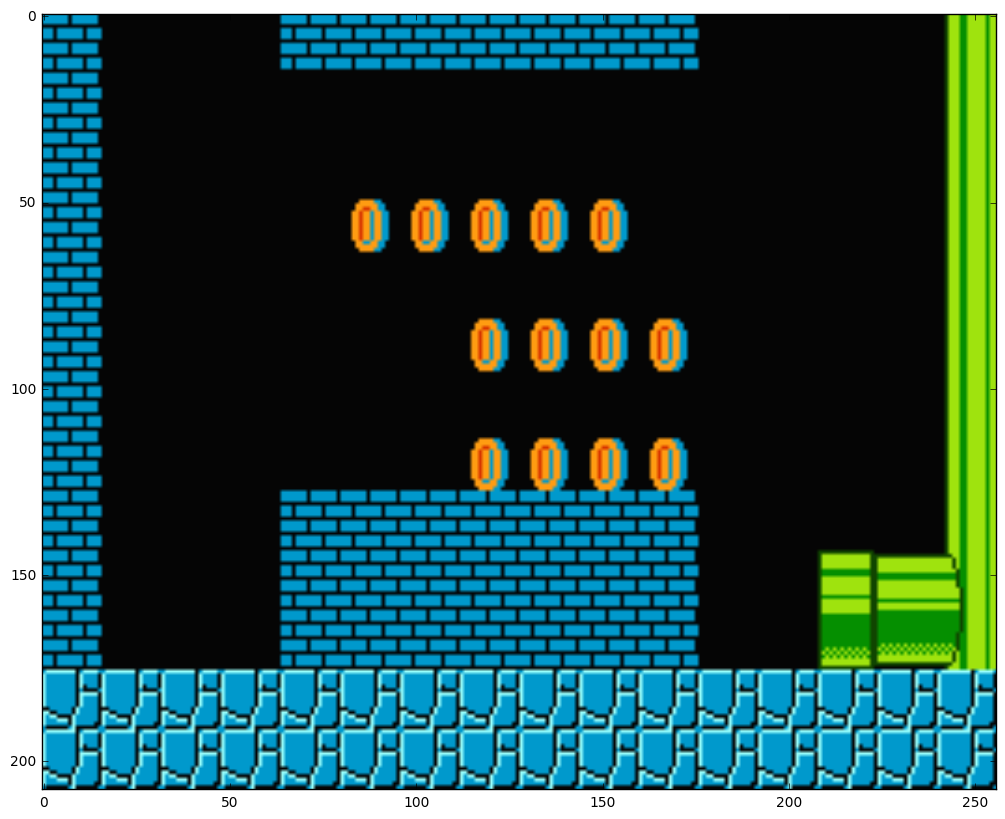

In [4]:

from collections import Counter
posx, posy = 0, 0
nt_total = {}
potential_nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False
prev = None
curr = None
gap =10
big_gap = 60
timeSinceControl = 0
thresh =1
accum = 0
screen_offsets = {}
room_v_time = {}
accumX = 0
accumY = 0
potential_interstitial = False
correlation_threshold = 0.1
room_start_x = 0
room_start_y = 0
room_starts = {0:(0,0)}
previousTimeSinceControl = 0
raw_scrolls = {}
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    if t not in ep_data['screen_corrs']:
        ep_data['screen_corrs'][t] = 1
    #print t, len(ep_data["nametables"])
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    pal = ep_data['palettes'][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    tilex += sx
    tiley += sy
        
    raw_scrolls[t] = (tilex,tiley)
    if not ep_data['has_controls'][t]:
        timeSinceControl += 1
    else:
        previousTimeSinceControl = timeSinceControl
        timeSinceControl  = 0
        accumX = 0
        accumY = 0
    if timeSinceControl > 0:
        accumX += sx
        accumY += sy
    if timeSinceControl > gap and ((abs(accumX) >= scroll_area[2]/2 or
                                    abs(accumY) >= scroll_area[3]/2) or 
                                   timeSinceControl > big_gap):
        if not interstitial:
            #print t, timeSinceControl
            #plt.imshow(nt)
            #plt.show()
            pass
        interstitial = True
        potential_nt_total = {}
        potential_interstitial = False
    elif timeSinceControl > gap:
        potential_interstitial  = True
    else:
        if potential_interstitial:
            for key in potential_nt_total:
                if key not in nt_total:
                    nt_total[key] = {}
                for t_ in potential_nt_total[key]:
                    nt_total[key][t_] = potential_nt_total[key][t_]
            potential_nt_total = {}
            potential_interstitial = False
    #print t, timeSinceControl
    if  not (interstitial or potential_interstitial) :
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    if potential_interstitial:
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in potential_nt_total:
                    potential_nt_total[key] = {}
                potential_nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    if (ep_data['screen_corrs'][t]<correlation_threshold) and ep_data['screen_corrs'][t] > 0:
        
        interstitial = True
    prev = curr
    curr = {}
    diff = 0
    for x in range(0, scroll_area[2]):
        for y in range(0, scroll_area[3]):
            key = (y+tiley, x+tilex)
            if key not in curr:
                curr[key] = (int(nt[y, x]),int(attr[y, x]))
            if prev:
                if key not in prev:
                    diff += 1
                elif curr[key] != prev[key]:
                    diff += 1  
    if (diff > scroll_area[2]*scroll_area[3]*thresh):
        interstitial = True
    #print t, timeSinceControl,interstitial,potential_interstitial,float(diff)/float(scroll_area[2]*scroll_area[3]),accumX,accumY
    
    if ((ep_data['has_controls'][t] and interstitial) or (diff > scroll_area[2]*scroll_area[3]*thresh)) and (ep_data['screen_corrs'][t]>correlation_threshold):
        plt.imshow(nt,interpolation='none')
        plt.show()
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
        for t_ in range(t-previousTimeSinceControl,t):
            room_v_time[t] = len(nt_totals)-1
        room_starts[len(nt_totals)-1] = (ep_data["screen_scrolls"][t][0],
                                         ep_data["screen_scrolls"][t][1])
    room_v_time[t] = len(nt_totals)-1
    if t in ep_data["screen_scrolls"]:       
        screen_offsets[t] = (ep_data["screen_scrolls"][t][0],
                             ep_data["screen_scrolls"][t][1])
    else:
        screen_offsets[t] = (tilex*8,tiley*8)

room_images = []
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind_per_tile = nt_result[y,x].values()
                    i2c = {}
                    for i in ind_per_tile:
                        if i not in i2c:
                            i2c[i] = 0
                        i2c[i] += 1
                    
                    #ind = sorted(nt_result[y, x])

                    #ind = ind[int(len(ind)/4.0)]
                    col = colorized[sorted(i2c.iteritems(), key=lambda (k,v): (v,k))[-1][0]]  # Returns the highest occurring item
                    
                    #col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        room_images.append((out_image,(0,(maxx-minx)*8,0,(maxy-miny)*8)))
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

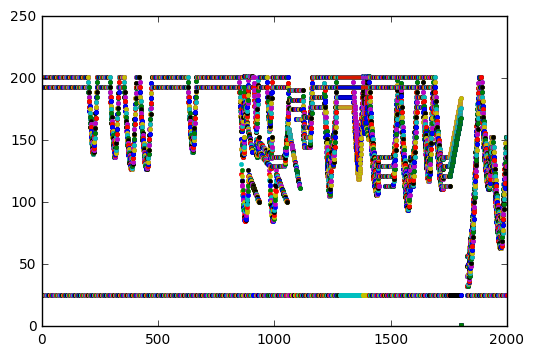

CPU times: user 1min 3s, sys: 620 ms, total: 1min 4s
Wall time: 1min 3s


In [13]:
%%time
import tracking
reload(tracking)


tracks, old_tracks = tracking.tracks_from_sprite_data(ep_data['sprite_data'],sigma=5,min_gate=5)
for track in tracks:
    old_tracks.append((track,tracks[track]))
   

[ 122.   89.]
[ 121.   91.]
[ 120.   93.]
[ 119.   94.]
[ 118.   94.]
[ 117.   95.]
[ 116.   95.]
[ 115.   95.]
[ 113.   94.]
[ 112.   93.]
[ 111.   92.]
[ 110.   91.]
[ 108.   89.]
[ 107.   87.]
[ 107.   87.]
[ 107.   87.]
[ 107.   87.]
[ 107.   87.]
[ 107.   87.]
[ 107.   87.]


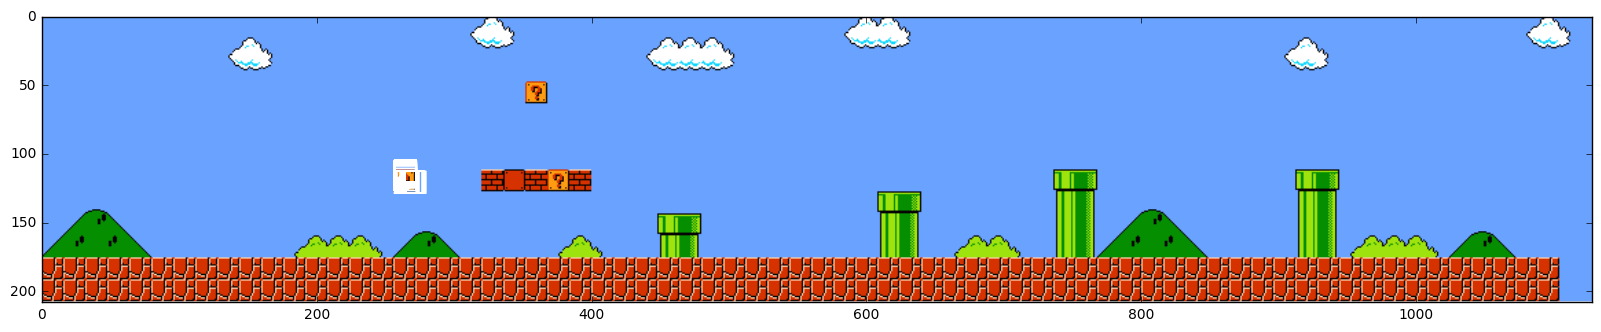

[ 119.   60.]
[ 119.   61.]
[ 119.   62.]
[ 119.   63.]
[ 119.   64.]
[ 119.   65.]
[ 119.   66.]
[ 119.   67.]
[ 119.   68.]
[ 119.   69.]
[ 119.   70.]
[ 119.   71.]
[ 119.   72.]
[ 119.   73.]
[ 119.   74.]
[ 119.   75.]
[ 119.   76.]
[ 119.   77.]
[ 119.   78.]
[ 119.   79.]
[ 119.   80.]
[ 119.   81.]
[ 119.   82.]
[ 119.   83.]
[ 119.   84.]
[ 119.   85.]
[ 119.   86.]
[ 119.   87.]
[ 119.   88.]
[ 119.   89.]
[ 119.   90.]
[ 119.   91.]
[ 119.   92.]
[ 119.   93.]
[ 119.   94.]
[ 119.   95.]
[ 119.   95.]
[ 119.   95.]
[ 119.   95.]
[ 119.   95.]
[ 119.   95.]
[ 119.   95.]


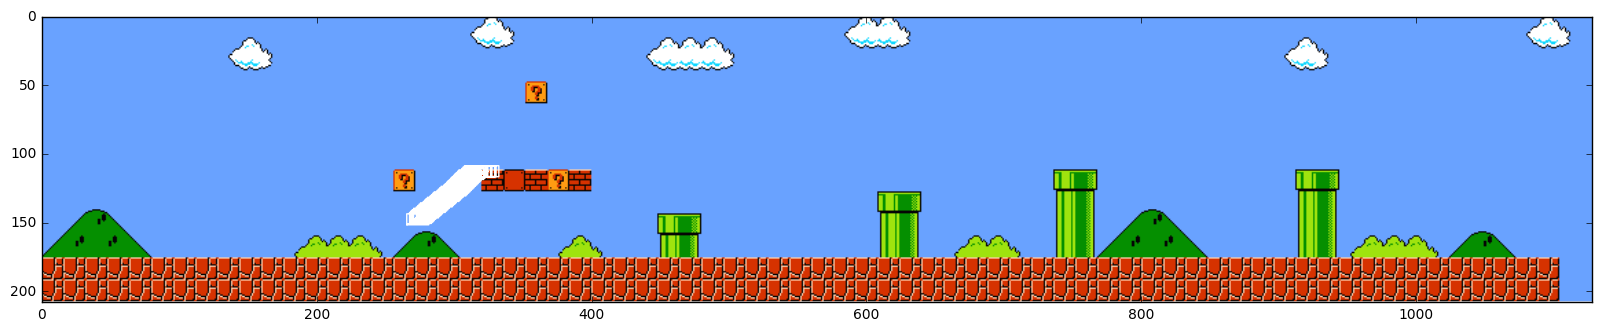

[ 259.   39.]
[ 256.   39.]
[ 254.   39.]
[ 255.   39.]
[ 254.   39.]
[ 251.   39.]
[ 249.   39.]
[ 246.   39.]
[ 245.   39.]
[ 242.   39.]
[ 241.   39.]
[ 238.   39.]
[ 237.   39.]
[ 234.   39.]
[ 233.   39.]
[ 231.   39.]
[ 230.   39.]
[ 227.   39.]
[ 226.   39.]
[ 224.   39.]
[ 223.   39.]
[ 221.   39.]
[ 220.   39.]
[ 219.   39.]
[ 218.   39.]
[ 216.   39.]
[ 215.   39.]
[ 214.   39.]
[ 213.   39.]
[ 212.   39.]
[ 212.   39.]
[ 211.   39.]
[ 211.   39.]
[ 210.   39.]
[ 210.   39.]
[ 209.   39.]
[ 209.   39.]
[ 208.   39.]
[ 208.   39.]
[ 207.   39.]
[ 207.   39.]
[ 206.   39.]
[ 206.   39.]
[ 205.   39.]
[ 205.   39.]
[ 204.   39.]
[ 203.   39.]
[ 202.   39.]
[ 202.   39.]
[ 200.   39.]
[ 200.   39.]
[ 198.   39.]
[ 198.   39.]
[ 196.   39.]
[ 196.   39.]
[ 195.   39.]
[ 195.   39.]
[ 194.   39.]
[ 194.   39.]
[ 193.   39.]
[ 193.   39.]
[ 192.   39.]
[ 192.   39.]
[ 191.   39.]
[ 191.   39.]
[ 190.   39.]
[ 190.   39.]
[ 189.   39.]
[ 189.   39.]
[ 188.   39.]
[ 188.   39.]
[ 187.

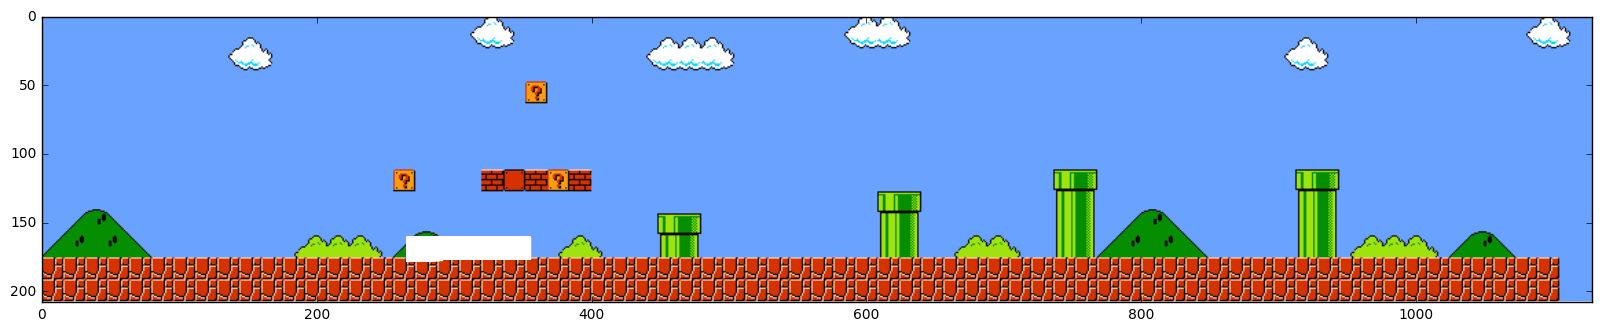

[ 123.  109.]
[ 122.  114.]
[ 121.  119.]
[ 120.  123.]
[ 119.  126.]
[ 118.  130.]
[ 117.  133.]
[ 116.  136.]
[ 114.  138.]
[ 113.  140.]
[ 112.  142.]
[ 111.  144.]
[ 109.  145.]
[ 108.  146.]
[ 107.  147.]
[ 106.  147.]
[ 104.  147.]
[ 103.  147.]
[ 102.  146.]
[ 101.  145.]
[  99.  144.]
[  98.  142.]
[  97.  140.]
[  96.  138.]
[  94.  136.]
[  93.  133.]
[  92.  130.]
[  91.  126.]
[  89.  123.]
[  88.  119.]
[  87.  114.]
[  90.  114.]
[  90.  114.]
[  90.  115.]
[  90.  115.]
[  90.  116.]
[  90.  116.]
[  90.  117.]
[  90.  117.]
[  90.  118.]
[  90.  118.]
[  90.  119.]
[  90.  119.]
[  90.  120.]
[  90.  120.]
[  90.  121.]
[  90.  121.]
[  90.  122.]
[  90.  122.]
[  90.  123.]
[  90.  123.]
[  90.  124.]
[  90.  124.]
[  90.  125.]
[  90.  125.]
[  90.  126.]
[  90.  126.]
[  90.  127.]
[  90.  127.]
[  90.  128.]
[  90.  128.]
[  90.  129.]
[  90.  129.]
[  90.  130.]
[  90.  130.]
[  90.  131.]
[  90.  131.]
[  90.  132.]
[  90.  132.]
[  90.  133.]
[  90.  133.]
[  90.

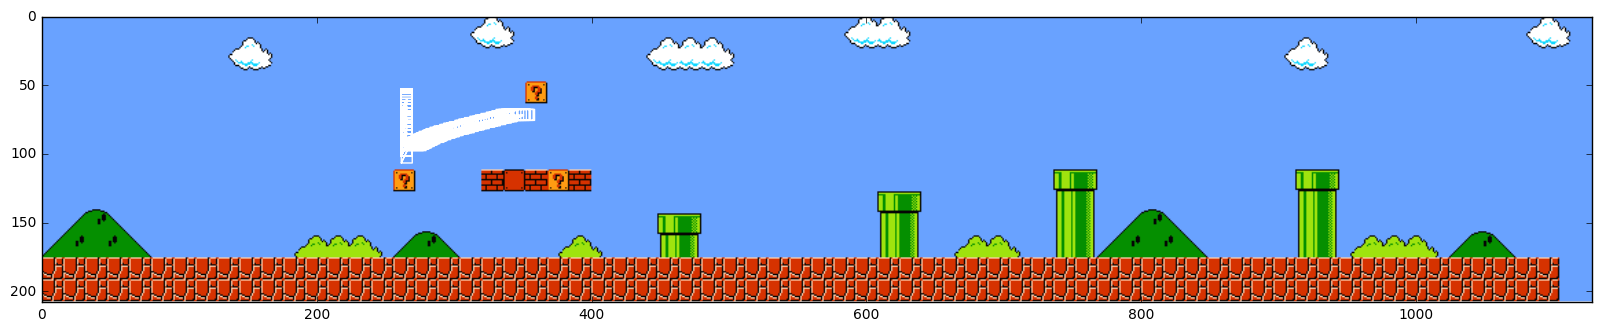

[ 100.   91.]
[ 100.   92.]
[ 100.   93.]
[ 100.   94.]
[ 100.   94.]
[ 100.   94.]
[ 100.   94.]
[ 100.   94.]
[ 100.   93.]
[ 100.   92.]
[ 100.   90.]
[ 100.   89.]
[ 100.   87.]
[ 100.   87.]
[ 100.   87.]
[ 100.   87.]
[ 100.   87.]
[ 100.   87.]
[ 100.   87.]


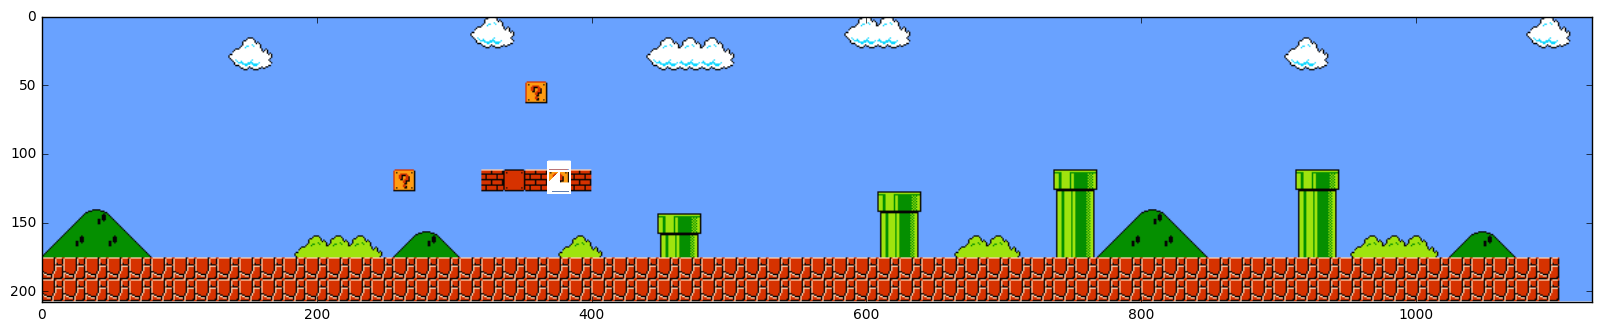

[ 101.  109.]
[ 101.  114.]
[ 101.  119.]
[ 101.  123.]
[ 101.  126.]
[ 101.  130.]
[ 101.  133.]
[ 101.  136.]
[ 101.  138.]
[ 101.  140.]
[ 101.  142.]
[ 101.  144.]
[ 101.  145.]
[ 101.  146.]
[ 101.  147.]
[ 101.  147.]
[ 101.  147.]
[ 101.  147.]
[ 101.  146.]
[ 101.  145.]
[ 101.  144.]
[ 101.  142.]
[ 101.  140.]
[ 101.  138.]
[ 101.  136.]
[ 101.  133.]
[ 101.  130.]
[ 101.  126.]
[ 101.  123.]
[ 101.  119.]
[ 101.  114.]
[ 105.  113.]
[ 105.  114.]
[ 105.  114.]
[ 105.  115.]
[ 105.  115.]
[ 105.  116.]
[ 105.  116.]
[ 105.  117.]
[ 105.  117.]
[ 105.  118.]
[ 105.  118.]
[ 105.  119.]
[ 105.  119.]
[ 105.  120.]
[ 105.  120.]
[ 105.  121.]
[ 105.  121.]
[ 105.  122.]
[ 105.  122.]
[ 105.  123.]
[ 105.  123.]
[ 105.  124.]
[ 105.  124.]
[ 105.  125.]
[ 105.  125.]
[ 105.  126.]
[ 105.  126.]
[ 105.  127.]
[ 105.  127.]
[ 105.  128.]
[ 105.  128.]
[ 105.  129.]
[ 105.  129.]
[ 105.  130.]
[ 105.  130.]
[ 105.  131.]
[ 105.  131.]
[ 105.  132.]
[ 105.  132.]
[ 105.  133.]
[ 105.

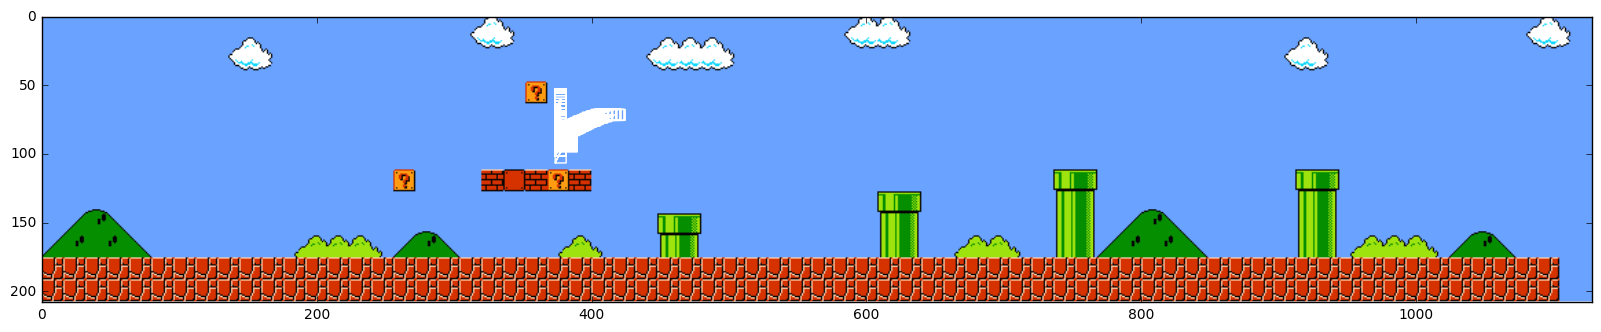

[ 123.   89.]
[ 121.   91.]
[ 119.   93.]
[ 117.   94.]
[ 115.   94.]
[ 113.   95.]
[ 111.   95.]
[ 109.   95.]
[ 107.   94.]
[ 105.   93.]
[ 103.   92.]
[ 101.   91.]
[ 99.  89.]
[ 97.  87.]
[ 97.  87.]
[ 97.  87.]
[ 92.  92.]
[ 90.  92.]
[ 88.  92.]
[ 87.  92.]
[ 85.  93.]
[ 84.  93.]
[ 82.  93.]
[ 81.  93.]
[ 79.  94.]
[ 78.  94.]
[ 77.  94.]
[ 75.  94.]
[ 74.  95.]
[ 73.  95.]
[ 72.  95.]
[ 71.  95.]
[ 70.  96.]
[ 69.  96.]
[ 69.  96.]
[ 68.  96.]
[ 68.  97.]
[ 68.  97.]
[ 68.  97.]
[ 68.  97.]
[ 68.  98.]
[ 68.  98.]
[ 68.  98.]
[ 68.  98.]
[ 68.  99.]
[ 68.  99.]
[ 68.  99.]
[ 68.  99.]
[  68.  100.]
[  68.  100.]
[  68.  100.]
[  68.  100.]
[  68.  101.]
[  68.  101.]
[  68.  101.]
[  68.  101.]
[  68.  102.]
[  68.  102.]
[  68.  102.]
[  68.  102.]
[  68.  103.]
[  68.  103.]
[  68.  103.]
[  68.  103.]
[  68.  104.]
[  69.  104.]
[  70.  104.]
[  71.  104.]
[  72.  104.]
[  73.  103.]
[  74.  103.]
[  75.  103.]
[  76.  103.]
[  77.  103.]
[  78.  103.]
[  79.  103.]
[  80.  

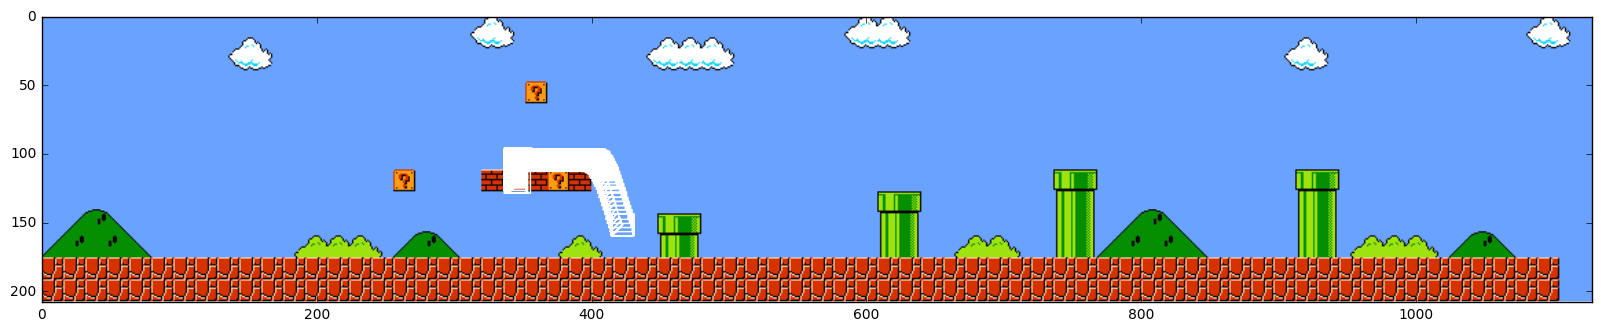

[ 108.   77.]
[ 108.   78.]
[ 108.   79.]
[ 108.   80.]
[ 108.   81.]
[ 108.   82.]
[ 108.   83.]
[ 108.   84.]
[ 108.   85.]
[ 108.   86.]
[ 108.   87.]
[ 108.   88.]
[ 108.   89.]
[ 108.   90.]
[ 108.   91.]
[ 108.   92.]
[ 108.   93.]
[ 108.   94.]
[ 108.   95.]
[ 108.   96.]
[ 108.   97.]
[ 108.   98.]
[ 108.   99.]
[ 108.  100.]
[ 108.  101.]
[ 108.  102.]
[ 108.  103.]
[ 108.  104.]
[ 108.  105.]
[ 108.  106.]
[ 108.  107.]
[ 108.  108.]
[ 108.  109.]
[ 108.  110.]
[ 108.  111.]
[ 108.  112.]
[ 108.  113.]
[ 108.  114.]
[ 108.  115.]
[ 108.  116.]
[ 108.  117.]
[ 108.  118.]
[ 108.  119.]
[ 108.  120.]
[ 108.  121.]
[ 108.  122.]
[ 108.  123.]
[ 108.  124.]
[ 108.  124.]
[ 108.  124.]
[ 108.  124.]
[ 108.  124.]
[ 108.  124.]
[ 108.  124.]


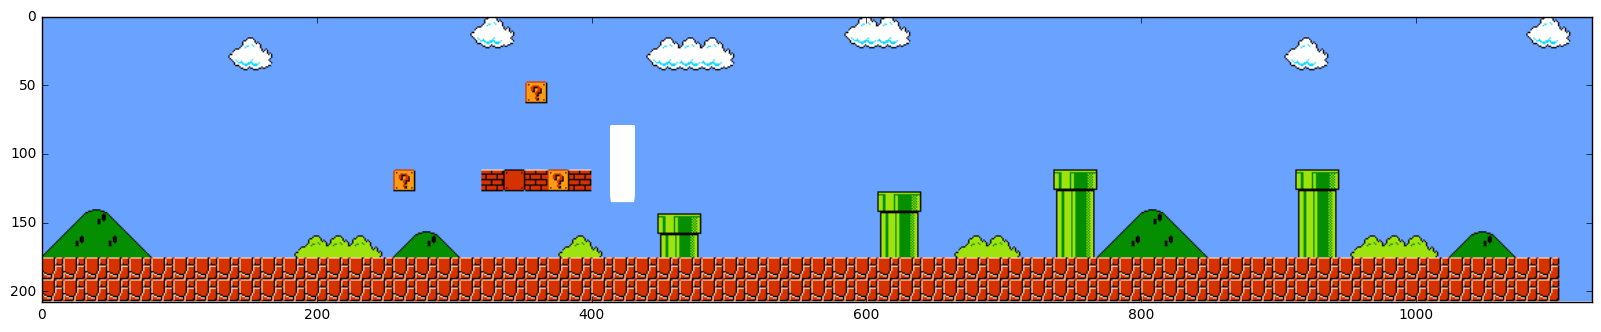

[ 85.  60.]
[ 85.  61.]
[ 85.  62.]
[ 85.  63.]
[ 85.  64.]
[ 85.  65.]
[ 85.  66.]
[ 85.  67.]
[ 85.  68.]
[ 85.  69.]
[ 85.  70.]
[ 85.  71.]
[ 85.  72.]
[ 85.  73.]
[ 85.  74.]
[ 85.  75.]
[ 85.  76.]
[ 85.  77.]
[ 85.  78.]
[ 85.  79.]
[ 85.  80.]
[ 85.  81.]
[ 85.  82.]
[ 85.  83.]
[ 85.  84.]
[ 85.  85.]
[ 85.  85.]
[ 85.  85.]
[ 85.  85.]
[ 85.  85.]
[ 85.  85.]
[ 85.  85.]


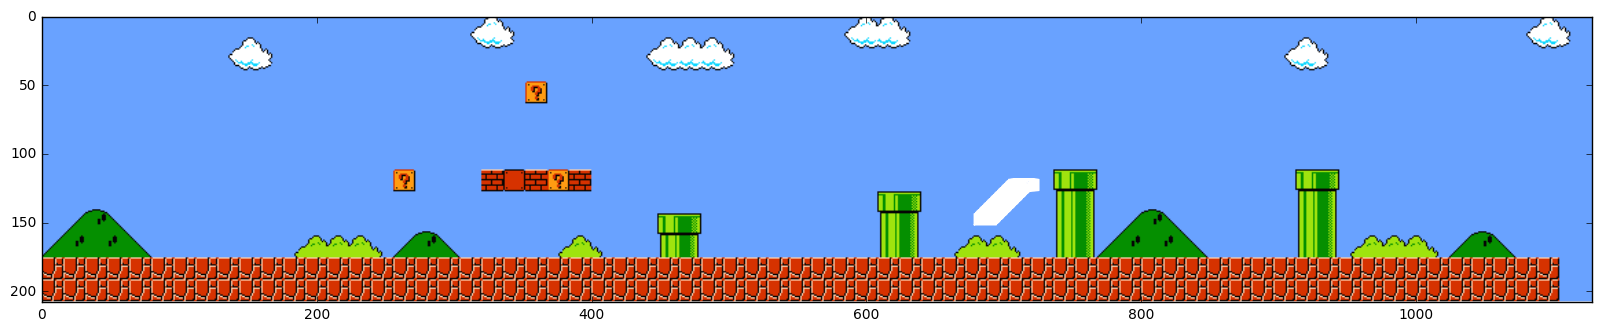

[ 259.   39.]
[ 259.   39.]
[ 257.   39.]
[ 256.   39.]
[ 255.   39.]
[ 254.   39.]
[ 252.   39.]
[ 255.   39.]
[ 253.   39.]
[ 252.   39.]
[ 250.   39.]
[ 249.   39.]
[ 247.   39.]
[ 245.   39.]
[ 243.   39.]
[ 242.   39.]
[ 239.   39.]
[ 238.   39.]
[ 235.   39.]
[ 234.   39.]
[ 231.   39.]
[ 230.   39.]
[ 227.   39.]
[ 226.   39.]
[ 223.   39.]
[ 222.   39.]
[ 219.   39.]
[ 218.   39.]
[ 215.   39.]
[ 214.   39.]
[ 211.   39.]
[ 210.   39.]
[ 207.   39.]
[ 206.   39.]
[ 203.   39.]
[ 202.   39.]
[ 199.   39.]
[ 198.   39.]
[ 195.   39.]
[ 194.   39.]
[ 191.   39.]
[ 190.   39.]
[ 187.   39.]
[ 186.   39.]
[ 183.   39.]
[ 182.   39.]
[ 180.   39.]
[ 179.   39.]
[ 176.   39.]
[ 175.   39.]
[ 173.   39.]
[ 172.   39.]
[ 169.   39.]
[ 168.   39.]
[ 166.   39.]
[ 165.   39.]
[ 162.   39.]
[ 161.   39.]
[ 159.   39.]
[ 158.   39.]
[ 155.   39.]
[ 154.   39.]
[ 152.   39.]
[ 151.   39.]
[ 149.   39.]
[ 148.   39.]
[ 146.   39.]
[ 145.   39.]
[ 143.   39.]
[ 143.   39.]
[ 141.   39.]
[ 141.

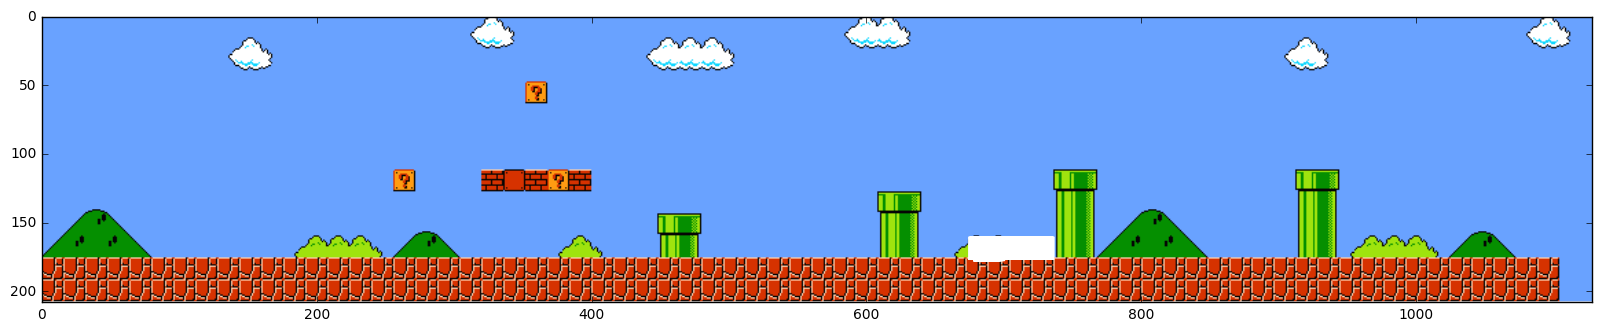

[ 257.   39.]
[ 254.   39.]
[ 252.   39.]
[ 253.   39.]
[ 251.   39.]
[ 248.   39.]
[ 247.   39.]
[ 244.   39.]
[ 243.   39.]
[ 240.   39.]
[ 239.   39.]
[ 237.   39.]
[ 236.   39.]
[ 234.   39.]
[ 233.   39.]
[ 232.   39.]
[ 231.   39.]
[ 230.   39.]
[ 230.   39.]
[ 229.   39.]
[ 229.   39.]
[ 228.   39.]
[ 228.   39.]
[ 227.   39.]
[ 227.   39.]
[ 226.   39.]
[ 226.   39.]
[ 225.   39.]
[ 225.   39.]
[ 224.   39.]
[ 224.   39.]
[ 223.   39.]
[ 223.   39.]
[ 222.   39.]
[ 222.   39.]
[ 221.   39.]
[ 221.   39.]
[ 220.   39.]
[ 220.   39.]
[ 219.   39.]
[ 219.   39.]
[ 218.   39.]
[ 218.   39.]
[ 217.   39.]
[ 217.   39.]
[ 216.   39.]
[ 216.   39.]
[ 215.   39.]
[ 215.   39.]
[ 214.   39.]
[ 214.   39.]
[ 213.   39.]
[ 213.   39.]
[ 212.   39.]
[ 212.   39.]
[ 211.   39.]
[ 211.   39.]
[ 210.   39.]
[ 210.   39.]
[ 209.   39.]
[ 209.   39.]
[ 208.   39.]
[ 208.   39.]
[ 207.   39.]
[ 207.   39.]
[ 206.   39.]
[ 206.   39.]
[ 205.   39.]
[ 205.   39.]
[ 204.   39.]
[ 204.   39.]
[ 203.

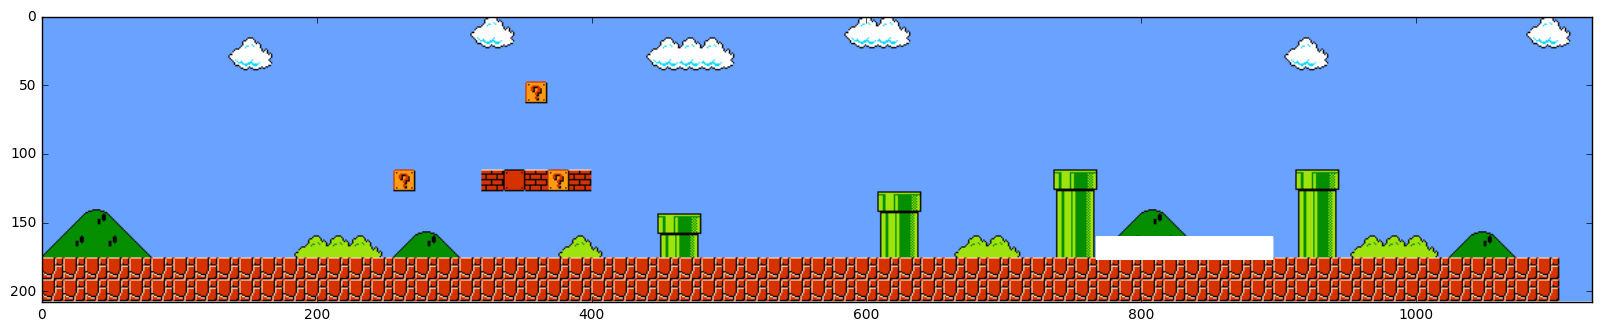

[ 258.   39.]
[ 257.   39.]
[ 255.   39.]
[ 254.   39.]
[ 252.   39.]
[ 252.   39.]
[ 254.   39.]
[ 254.   39.]
[ 253.   39.]
[ 253.   39.]
[ 252.   39.]
[ 252.   39.]
[ 251.   39.]
[ 251.   39.]
[ 250.   39.]
[ 250.   39.]
[ 249.   39.]
[ 249.   39.]
[ 248.   39.]
[ 248.   39.]
[ 247.   39.]
[ 247.   39.]
[ 246.   39.]
[ 246.   39.]
[ 245.   39.]
[ 245.   39.]
[ 244.   39.]
[ 244.   39.]
[ 243.   39.]
[ 243.   39.]
[ 242.   39.]
[ 242.   39.]
[ 241.   39.]
[ 241.   39.]
[ 240.   39.]
[ 240.   39.]
[ 239.   39.]
[ 239.   39.]
[ 238.   39.]
[ 238.   39.]
[ 237.   39.]
[ 237.   39.]
[ 236.   39.]
[ 236.   39.]
[ 235.   39.]
[ 235.   39.]
[ 234.   39.]
[ 234.   39.]
[ 233.   39.]
[ 233.   39.]
[ 232.   39.]
[ 232.   39.]
[ 231.   39.]
[ 231.   39.]
[ 230.   39.]
[ 230.   39.]
[ 229.   39.]
[ 229.   39.]
[ 228.   39.]
[ 228.   39.]
[ 227.   39.]
[ 227.   39.]
[ 226.   39.]
[ 226.   39.]
[ 225.   39.]
[ 225.   39.]
[ 224.   39.]
[ 224.   39.]
[ 223.   39.]
[ 223.   39.]
[ 222.   39.]
[ 222.

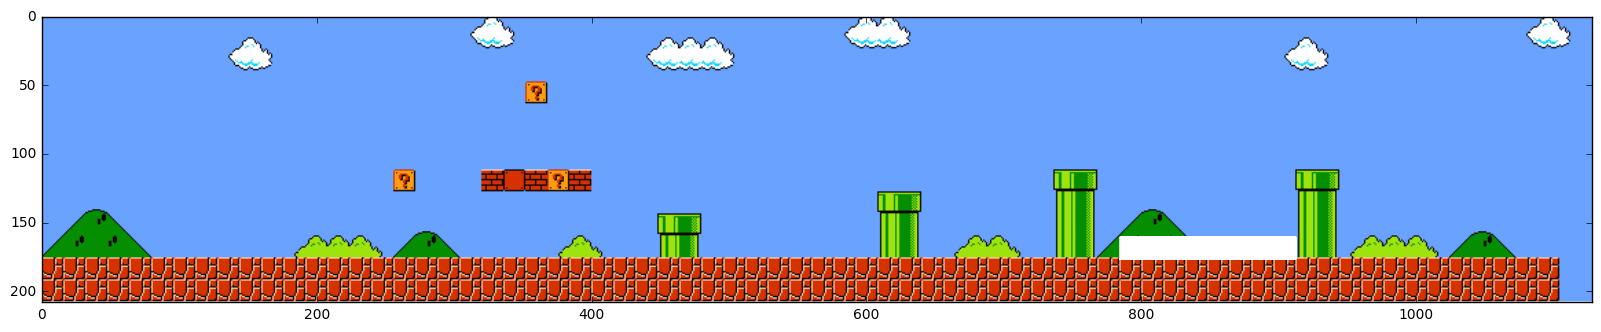

[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 48.  39.]
[ 49.  39.]
[ 49.  39.]
[ 49.  39.]
[ 50.  39.]
[ 50.  39.]
[ 50.  39.]
[ 51.  39.]
[ 51.  39.]
[ 52.  39.]
[ 53.  39.]
[ 53.  39.]
[ 54.  39.]
[ 55.  39.]
[ 55.  39.]
[ 56.  39.]
[ 57.  39.]
[ 58.  39.]
[ 59.  39.]
[ 60.  39.]
[ 60.  39.]
[ 61.  39.]
[ 62.  39.]
[ 63.  39.]
[ 63.  39.]
[ 64.  39.]
[ 65.  39.]
[ 65.  39.]
[ 66.  39.]
[ 66.  39.]
[ 67.  39.]
[ 67.  39.]
[ 67.  39.]
[ 68.  39.]
[ 68.  39.]
[ 68.  39.]
[ 69.  39.]
[ 69.  39.]
[ 69.  39.]
[ 69.  39.]
[ 69.  39.]
[ 69

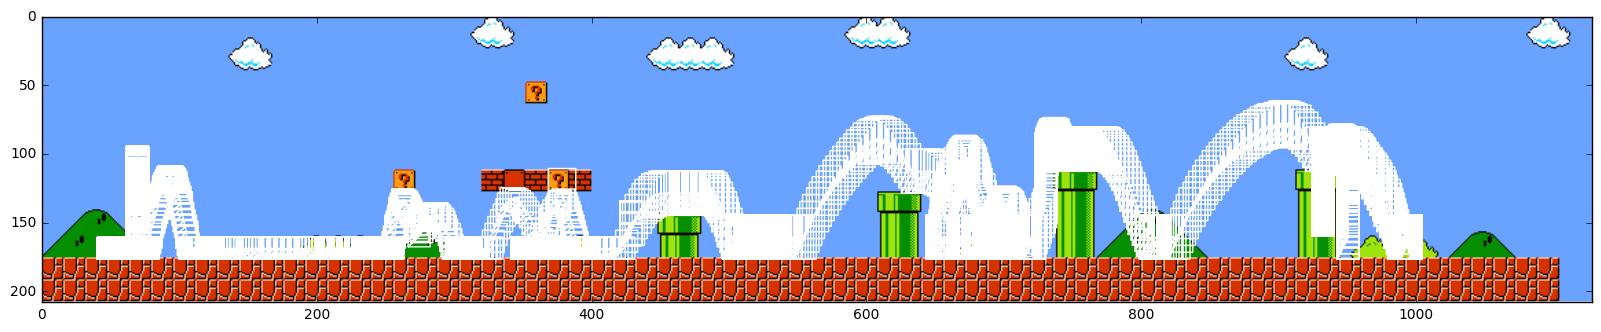

[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.

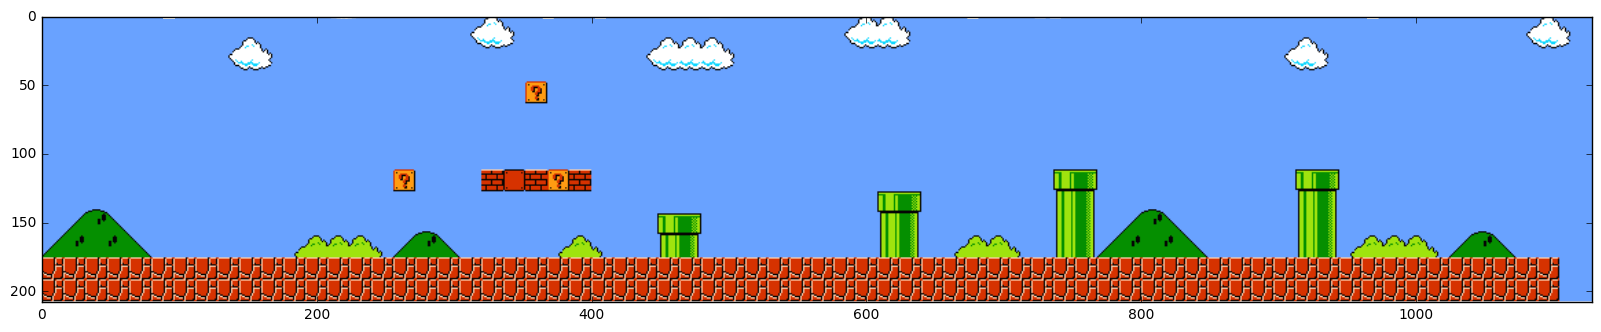

[   4.  235.]
[   4.  235.]
[   4.  235.]
[   4.  235.]
[   4.  235.]
[   4.  235.]


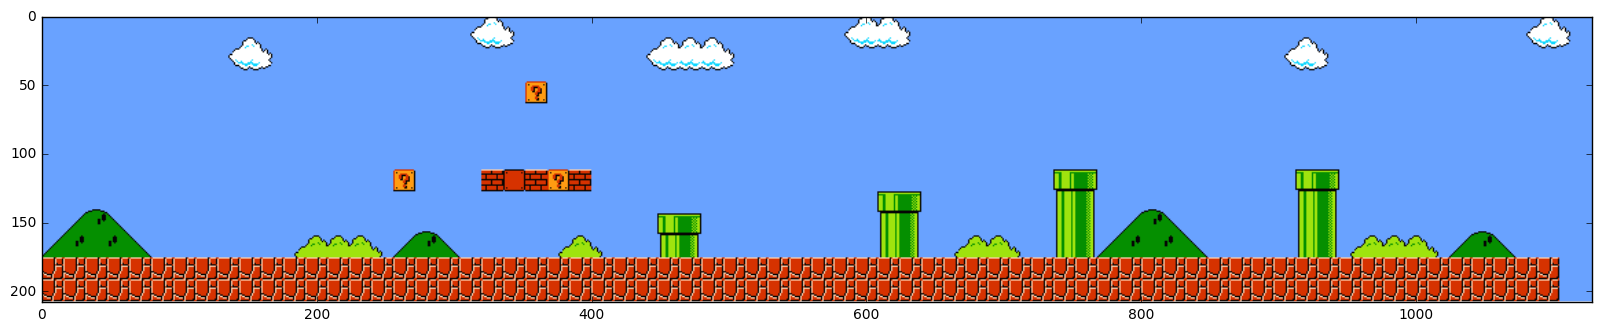

[  32.  191.]
[  32.  191.]
[  32.  191.]
[  32.  191.]
[  32.  191.]
[  32.  191.]
[  32.  190.]
[  32.  189.]
[  32.  188.]
[  32.  187.]
[  32.  186.]
[  32.  184.]
[  32.  183.]
[  32.  181.]
[  32.  179.]
[  32.  177.]
[  32.  175.]
[  32.  175.]
[  32.  173.]
[  32.  170.]
[  32.  168.]
[  32.  165.]
[  32.  162.]
[  32.  159.]
[  32.  155.]
[  32.  152.]
[  32.  148.]
[  32.  145.]
[  32.  141.]
[  32.  137.]
[  32.  132.]
[  32.  128.]
[  32.  124.]
[  32.  120.]
[  32.  116.]
[  32.  111.]
[  32.  107.]
[  32.  103.]
[ 32.  99.]
[ 32.  94.]
[ 32.  90.]
[ 32.  86.]
[ 32.  82.]
[ 32.  77.]
[ 32.  73.]
[ 32.  69.]
[ 32.  65.]
[ 32.  60.]
[ 32.  56.]
[ 33.  52.]
[ 33.  48.]
[ 33.  47.]
[ 34.  47.]
[ 34.  47.]
[ 35.  47.]
[ 35.  47.]
[ 36.  47.]
[ 36.  47.]
[ 37.  47.]
[ 38.  47.]
[ 39.  47.]
[ 40.  47.]
[ 41.  47.]
[ 42.  51.]
[ 43.  55.]
[ 44.  59.]
[ 45.  63.]
[ 46.  66.]
[ 47.  70.]
[ 48.  73.]
[ 50.  76.]
[ 51.  79.]
[ 52.  82.]
[ 54.  85.]
[ 55.  87.]
[ 56.  90.]
[ 58.  92.]


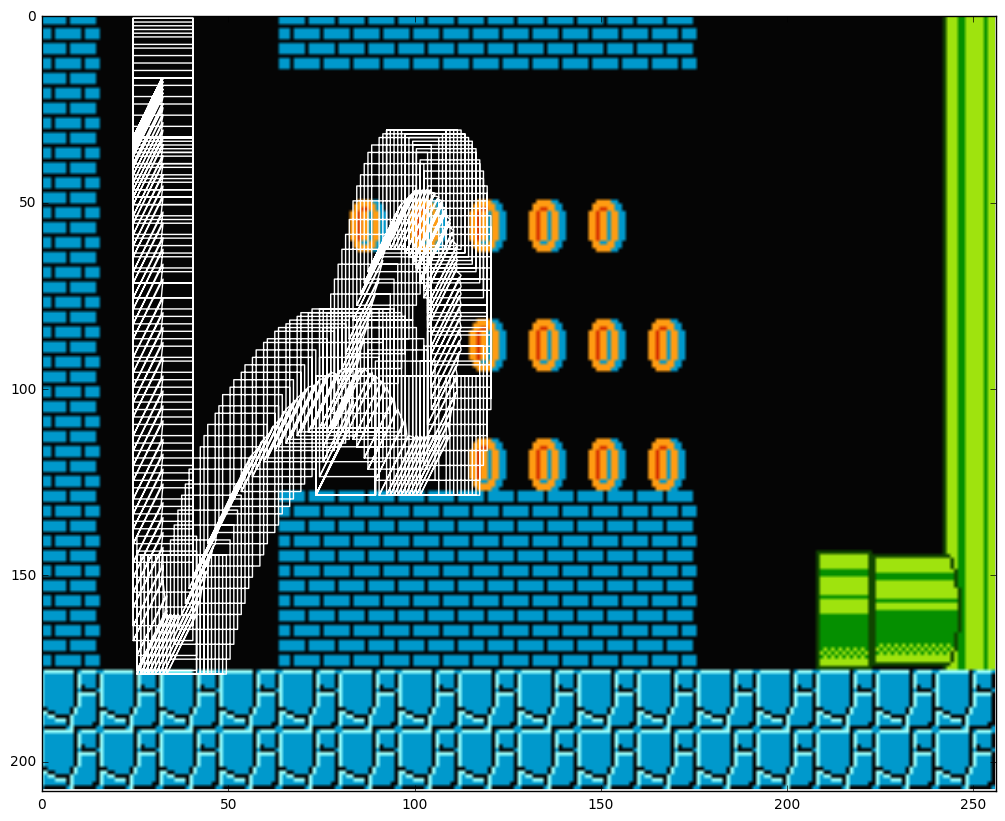

[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.  211.]
[  92.

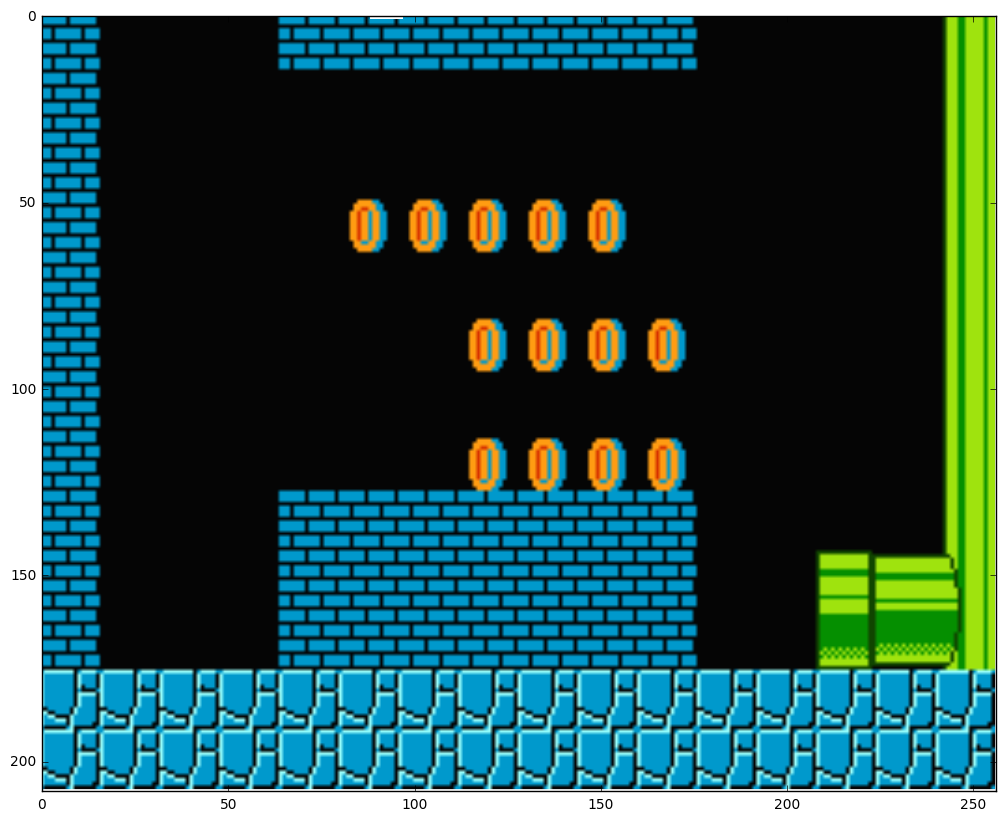

In [17]:

for track in old_tracks:
    pts = []
    for t in sorted(track[1]):
        room_ids = {}
        most_seen = -1
        most_times_seen = -1
        
        if t in screen_offsets:
            room_id = room_v_time[t]  
            if room_id not in room_ids:
                room_ids[room_id] = 0
            room_ids[room_id] += 1
            if room_ids[room_id] > most_times_seen:
                most_times_seen = room_ids[room_id]
                most_seen = room_id
    offset = np.array([0.5,0.5])
    actual_track = []
    for t in sorted(track[1]):
        if t in screen_offsets:
            #room_id = room_v_time[t]  
            #print t,room_id
            #print track[1][t][0],screen_offsets[t]np.array(room_starts[most_seen])
            pts.append(track[1][t][0]+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))
            actual_track.append(pts)
            print track[1][t][0]
            bounding_box = track[1][t][1]
            half_extent = np.array(bounding_box[-2:])/2.0
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([-1,1]))
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([1,-1]))
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))
            
    pts = np.array(pts)
    plt.figure(figsize=(20,10)) 
    plt.imshow(room_images[room_id][0],origin='upper')
    plt.plot(pts[:,0],208-pts[:,1],'w')
    plt.axis([room_images[room_id][1][0],room_images[room_id][1][1],room_images[most_seen][1][3],room_images[most_seen][1][2]])
    plt.show()


In [7]:
def room2attr(room):
    
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1
    attr_room = np.zeros((maxy-miny,maxx-minx,2))
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in room:
                ind = sorted(room[y, x])[0]
                attr_room[int(y-miny), int(x-minx),:] = np.array(room[(y, x)][ind][:-1])
    return attr_room
unions = UnionFind()

def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    intersect_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in intersect_keys if d1[o] != d2[o]}
    same = set(o for o in intersect_keys if d1[o] == d2[o])
    return added, removed, modified, same

for room_id,room in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1

    for other_id,other in enumerate(nt_totals):
        if len(room) > 0 and len(other) > 0:
            if room2attr(room).shape == room2attr(other).shape:
                if np.sum(np.abs(room2attr(room)-room2attr(other))) == 0:
                    unions.union(room_id,other_id)

            
cluster2room = {}

for u in unions:
    if unions[u] not in cluster2room:
        cluster2room[unions[u]] = set()
    cluster2room[unions[u]].add(u)
print 'digraph G{\n\trankdir=LR;\npenwidth=10;\nnode[shape=none];\n'

for cluster in cluster2room:
    print '\tsubgraph cluster_{} {{'.format(cluster)
    print '\t\tcolor=blue;'
    for room in cluster2room[cluster]:
        print '\t\t n{}[image="{}.png", label="{}", fontsize=240,fontcolor=red];'.format(room,room,room);
    print '\t}'
for ii in range(1,len(nt_totals)):
    print 'n{} -> n{} [penwidth=10];'.format(ii-1,ii)
print '}'

NameError: name 'UnionFind' is not defined

In [187]:
import random

def encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev != '':
                entry = (prev,count)
                lst.append(entry)
                #print lst
            count = 1
            prev = character
        else:
            count += 1
    else:
        entry = (character,count)
        lst.append(entry)
    return lst
def get_cycles(trace,split):
    index = 0
    new_trace = []
    cycles = {}
    for s in split:    
        cycle = tuple(trace[index:index+s])
        index += s
        if cycle not in cycles:
            cycles[cycle] = len(cycles)
        new_trace.append(cycles[cycle])
    return cycles,new_trace
    
def score(trace,split):
    cycles,new_trace = get_cycles(trace,split)
    rle_encoded  = encode(new_trace)
    size = 0
    for s in cycles:
        size += len(s)
    return size+len(rle_encoded),rle_encoded
        
def mutate(split):
    split_id = random.randint(0,len(split)-1)
    new_split = [s for s in split]
    if random.random() < 0.5 and split[split_id] > 1:
        split_left = split[split_id]
        split_right = random.randint(1,split_left)
        split_left -= split_right
        if not (split_left == 0 or split_right == 0):
            new_split = new_split[:split_id] + [split_left,split_right] + new_split[split_id+1:]
    elif split_id != 0:
        new_split =  new_split[:split_id-1] + [ new_split[split_id-1]+new_split[split_id]] + new_split[split_id+1:]
    return new_split

def crossover(split_left,split_right):
    sum = reduce(lambda x,y:x+y,split_left)
    crossover_point = random.randint(1,sum-1)
    running_total = 0
    left_left = []
    left_right = []
    for left_point in range(len(split_left)):
        running_total += split_left[left_point]
        if running_total >= crossover_point:
            left_carry_over = running_total-crossover_point
            if left_carry_over == 0:
                left_left.append(split_left[left_point])
                left_right = split_left[left_point+1:]
            else:
                left_left.append(split_left[left_point]-left_carry_over)
                left_right = [left_carry_over]+split_left[left_point+1:]
            break
        left_left.append(split_left[left_point])
    right_left = []
    right_right = []
    running_total = 0
    for right_point in range(len(split_right)):
        running_total += split_right[right_point]
        if running_total >= crossover_point:
            right_carry_over = running_total-crossover_point
            if right_carry_over == 0:
                right_left.append(split_right[right_point])
                right_right = split_right[right_point+1:]
            else:
                right_left.append(split_right[right_point]-right_carry_over)
                right_right = [right_carry_over]+split_right[right_point+1:]
            break
        right_left.append(split_right[right_point])
    return left_left + right_right, right_left + left_right

def find_animations(data,population_size = 500,generations=500,proportion_to_keep=0.5,crossover_amount=0.1):
    keep_each = int(proportion_to_keep*population_size)
    crossover_amount = int(population_size*crossover_amount)
    best_score = float('inf')

    population = []
    for ii in range(population_size):
        splits = random.randint(0,len(data))
        split = [len(data)]
        for jj in range(splits):
            split_id = random.randint(0,len(split)-1)
            split_left = split[split_id]
            split_right = random.randint(1,split_left)
            split_left -= split_right
            if not (split_left == 0 or split_right == 0):
                split = split[:split_id] + [split_left,split_right] + split[split_id+1:]
        population.append(split)
    def score_population(population):
        scored = {}
        for split in population:
            current,encoded = score(data,split)
            if current not in scored:
                scored[current] = []
            scored[current].append(split)
        return scored

    print population[0]
    for generation in range(generations):
        current_population = []
        scored = score_population(population)
        for s in sorted(scored):
            current_population += scored[s]
        current_population = current_population[:keep_each]
        while len(current_population) != population_size:
            current_population.append(mutate(random.choice(current_population)))
        for ii in range(crossover_amount):
            id1 = random.randint(0,population_size-1)
            id2 = random.randint(0,population_size-1)
            new1,new2 = crossover(population[id1],population[id2])
            population[id1] = new1
            population[id2] = new2
        population = current_population
    
    scored = score_population(population)
    best_score = list(sorted(scored))[0]
    best_split = scored[best_score][0]
    print 'best_split',best_split
    cycles,new_trace = get_cycles(data,best_split)
    id2cycle = {v:k for k,v in cycles.items()}
    previous_cycle_id = -1
    animations = []
    animation_ids = []
    for cycle_id in new_trace:        
        print id2cycle[cycle_id]
        if cycle_id != previous_cycle_id and previous_cycle_id >= 0:
            overlap = 0
            for c,p in zip(id2cycle[cycle_id],id2cycle[previous_cycle_id]):
                if c == p:
                    overlap += 1
                else:
                    break
            if overlap > 0:
                animation_ids += [(previous_cycle_id,overlap), (cycle_id,len(id2cycle[cycle_id])-overlap)]
                animations += [id2cycle[cycle_id][:overlap], id2cycle[cycle_id][overlap:]]
            else:
                animation_ids.append((cycle_id,len(id2cycle[cycle_id])))
                animations.append(id2cycle[cycle_id])
        else:
            animation_ids.append((cycle_id,len(id2cycle[cycle_id])))
            animations.append(id2cycle[cycle_id])
        previous_cycle_id = cycle_id
    print animation_ids, animations
    
    
    return animation_ids, animations


for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
                    
                    ids = [nt_result[y-miny, x-minx][t] for t in sorted(nt_result[y-miny, x-minx])]
                    colors = [tuple(colorized[d].ravel()) for d in ids]
                    color_ids = {}
                    for c in colors:
                        if c not in color_ids:
                            color_ids[c] = len(color_ids)
                    colors = [color_ids[c] for c in colors]
                    
                    if len(set(colors)) > 1:
                        encoding = encode(colors)
                        time_independent = [e[0] for e in encoding]
                        animation_ids, animations = find_animations(time_independent)

[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 3, 4]
[12, 7, 2]
best_split [4, 4, 4, 4, 5]
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 1, 2, 3, 4)
[(0, 4), (0, 4), (0, 4), (0, 4), (0, 3), (1, 2)] [(0, 1, 2, 1), (0, 1, 2, 1), (0, 1, 2, 1), (0, 1, 2, 1), (0, 1, 2), (3, 4)]
11 [4, 4, 4, 4, 5] [(0, 4), (1, 1)]
[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 3, 4]
[1, 15, 1, 1, 1, 2]
best_split [1, 4, 4, 4, 4, 4]
(0,)
(1, 2, 1, 0)
(1, 2, 1, 0)
(1, 2, 1, 0)
(1, 2, 1, 0)
(1, 2, 3, 4)
[(0, 1), (1, 4), (1, 4), (1, 4), (1, 4), (1, 2), (2, 2)] [(0,), (1, 2, 1, 0), (1, 2, 1, 0), (1, 2, 1, 0), (1, 2, 1, 0), (1, 2), (3, 4)]
12 [1, 4, 4, 4, 4, 4] [(0, 1), (1, 4), (2, 1)]
[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 3, 4]
[4, 3, 4, 1, 1, 1, 5]
best_split [4, 4, 4, 4, 3]
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 1, 2, 1)
(0, 3, 4)
[(0, 4), (0, 4), (0, 4), (0, 4), (0, 1), (1, 2)] [(0, 1, 2, 1), (0, 1, 2, 1), (0, 1, 2, 1), (0, 1, 2, 1), (0,), (3, 4)]
9 [4, 4, 4, 4

KeyboardInterrupt: 